<insert quote from Sam and github repo for 2017 conference presentation>

> > __"The easiest way to make a good presentation is to include a lot of GIFs and Memes." - Sam Hamilton__

Link to Sam Hamilton's presentation for the 2017 Big Data Wisconsin Conference:
https://github.com/samhamil/Big_Data_Wisconsin_2017

In [113]:
from IPython.display import HTML
HTML('<img src="https://media.giphy.com/media/XOY5y7YXjTD7q/giphy.gif">')

# Setup

In [3]:
# import libraries

# data operations libraries
import pandas as pd
import numpy as np
import pickle

# visualization libraries
from IPython.display import HTML
from IPython.display import IFrame
from IPython.display import display
from IPython.display import Image


# data visualization libraries
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline 
matplotlib.rcParams['figure.figsize'] = (10,10)
import seaborn as sns


# machine learning libraries
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor

# data prep libraries
import patsy
from patsy import dmatrices
from functools import reduce
from sklearn import preprocessing

# other libraries
import os

In [94]:
# Read in the data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

#Combine data
full_data = pd.concat([train_data, test_data], axis=0)

In [95]:
#set indicies
train_data = train_data.set_index('PassengerId')
test_data = test_data.set_index('PassengerId')
full_data = full_data.set_index('PassengerId')

# First Pass at Modeling 

In [245]:
# Make a table to store model results
score_cols = ['Model','Precision','Recall','F1_Score','Accuracy','ROC_Area']
scores = pd.DataFrame(columns=score_cols)

In [246]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
smpl_data = train_data.select_dtypes(include=numerics)
smpl_data = smpl_data.fillna(smpl_data['Age'].mean(axis=0))
x = smpl_data.drop('Survived', axis=1)
smpl_data.head()
y = smpl_data['Survived']

In [247]:
full_data.index.size
smpl_data['Age'].mean(axis=0)

29.699117647058763

In [248]:
rf = RandomForestClassifier(n_estimators=100)
%time forestResults = rf.fit(x,y)
#x['forestPrediction'] = forestResults.predict(x)
x['forestPrediction'] = cross_val_predict(forestResults, x, y, cv=10)
x['forestPredicProba'] = cross_val_predict(forestResults, x, y, cv=10, method='predict_proba')[:,1]
t = pd.merge(x, y.to_frame(), left_index=True, right_index=True)



tn = t[(t.Survived == 0) & (t.forestPrediction==0)].index.size
fp = t[(t.Survived == 0) & (t.forestPrediction==1)].index.size
fn = t[(t.Survived == 1) & (t.forestPrediction==0)].index.size
tp = t[(t.Survived == 1) & (t.forestPrediction==1)].index.size

precision , recall, accuracy = (float(tp)/(tp+fp),float(tp)/(tp+fn), float(tp+tn)/float(tp+tn+fp+fn))
f1score = 2*precision * recall / (precision + recall)


print('\n Confusion Matrix')
display(
pd.DataFrame(data={' Predicted Survived': ['True Positive: '+str(tp), 'False Positive: '+str(fp)], 
                   'Predicted Not Survived': ['False Negative: '+str(fn), 'True Negative: '+str(tn)]}, index=['Survived','Not Survived']))

display(
pd.DataFrame(data={'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'], 
                   'Performance': [precision, recall, f1score, accuracy]}))

## Append to scores table
new_row = pd.DataFrame([['First_Pass_RF',precision, recall, f1score, accuracy,0]], columns=score_cols)
scores = scores.append(new_row)
# Update ROC score
scores.loc[scores['Model']=='First_Pass_RF',['ROC_Area']] = roc_auc_score(t['Survived'], x['forestPredicProba'])

CPU times: user 131 ms, sys: 874 µs, total: 132 ms
Wall time: 131 ms

 Confusion Matrix


,Predicted Survived,Predicted Not Survived
Survived,True Positive: 182,False Negative: 160
Not Survived,False Positive: 118,True Negative: 431


,Metric,Performance
0,Precision,0.606667
1,Recall,0.532164
2,F1 Score,0.566978
3,Accuracy,0.687991


In [86]:
HTML('<a href="https://imgflip.com/i/2ev9qj"><img src="https://i.imgflip.com/2ev9qj.jpg" title="made at imgflip.com"/></a>)')

# Domain Knowledge

Data:
https://www.kaggle.com/c/titanic/data

In [87]:
HTML('<img src="https://thumbnails-visually.netdna-ssl.com/titanic-by-the-numbers_5029174716f96.jpeg">')

In [88]:
HTML('<img src="http://incasellc.com/nat/wp-content/uploads/2014/05/titanicdetail1.png">')

In [8]:
HTML('<img src="https://discovernorthernireland.com/globalassets/things-to-do/attractions/titanic/titanic-infographic-updated.jpg">')

# Data Exploration 

Notes: This section is not needed for actually running the model

## Tabular

## Data Definitions 

In [38]:
data_description = {'Defnitition' : ['Survival', 'Ticket Class', 'Sex',
                                     'Age in years',
                                     '# of siblings + spouses aboard',
                                     '# of parents + children aboard',
                                     'Ticket Number', 'Passenger Fare',
                                     'Cabin Number', 'Port of Embarkation'],
                    'Variable' : ['Survival', 'pclass', 'sex', 'Age', 
                                  'sibsp', 'parch', 'ticket', 'fare',
                                  'cabin', 'embarked']
                   }
dataInfo = pd.DataFrame(data=data_description)
dataInfo.head(10)

,Defnitition,Variable
0,Survival,Survival
1,Ticket Class,pclass
2,Sex,sex
3,Age in years,Age
4,# of siblings + spouses aboard,sibsp
5,# of parents + children aboard,parch
6,Ticket Number,ticket
7,Passenger Fare,fare
8,Cabin Number,cabin
9,Port of Embarkation,embarked


###  Basic Commands

In [13]:
full_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599
3,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282
4,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803
5,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450


In [14]:
full_data.tail()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
1305,NaN,NaN,S,8.0500,"Spector, Mr. Woolf",0,3,male,0,NaN,A.5. 3236
1306,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1,female,0,NaN,PC 17758
1307,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,3,male,0,NaN,SOTON/O.Q. 3101262
1308,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,3,male,0,NaN,359309
1309,NaN,NaN,C,22.3583,"Peter, Master. Michael J",1,3,male,1,NaN,2668


In [15]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
Age         1046 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
Fare        1308 non-null float64
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    891 non-null float64
Ticket      1309 non-null object
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


In [16]:
full_data.dtypes

Age         float64
Cabin        object
Embarked     object
Fare        float64
Name         object
Parch         int64
Pclass        int64
Sex          object
SibSp         int64
Survived    float64
Ticket       object
dtype: object

__This is Big Data Wisconsin, but your dataset is 1309 records...__

In [35]:
HTML('<img src="https://qph.fs.quoracdn.net/main-qimg-583447a6b4cdd1a0148d1174ed2de1ee-c">')

Why this dataset was picked
* Good starting problem
* Has a lot of depth
* Easy to understand
* Not computationally intensive

Here are some things that we'd have to think about if our dataset was "Big"
 * Too many records to fit into memory
     * Have to sample from our dataset
      * Stratified Sampling
 * Too many features?
  * Dimensionality reduction
       * PCA, Isomap, etc

Here are some things we have to consider because our dataset is small
 * You should always have more samples than features, but the magnitude depends on the model being applied
 * Over-fitting is a real danger, especially for certain model types

In [17]:
full_data.describe()

,Age,Fare,Parch,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,3.000000,8.000000,1.000000


To show categorical variables, use include=['O']

In [7]:
full_data.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Hogeboom, Mrs. John C (Anna Andrews)",male,347082,B96 B98,S
freq,1,577,7,4,644


### Sub Selections

In [18]:
full_data['Sex'].head()

PassengerId
1      male
2    female
3    female
4    female
5      male
Name: Sex, dtype: object

In [19]:
(full_data['Age'] < 30).head()

PassengerId
1     True
2    False
3     True
4    False
5    False
Name: Age, dtype: bool

In [20]:
full_data[full_data['Age'] < 30].head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171
3,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282
8,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,3,male,3,0.0,349909
9,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,3,female,0,1.0,347742
10,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,2,female,1,1.0,237736


In [21]:
full_data.loc[full_data['Age'] < 30,["Name","Age"]].head()

,Name,Age
PassengerId,,
1,"Braund, Mr. Owen Harris",22.0
3,"Heikkinen, Miss. Laina",26.0
8,"Palsson, Master. Gosta Leonard",2.0
9,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27.0
10,"Nasser, Mrs. Nicholas (Adele Achem)",14.0


### Aggregation 

In [22]:
full_data['Sex'].value_counts()

male      843
female    466
Name: Sex, dtype: int64

## Visual 

### Age 

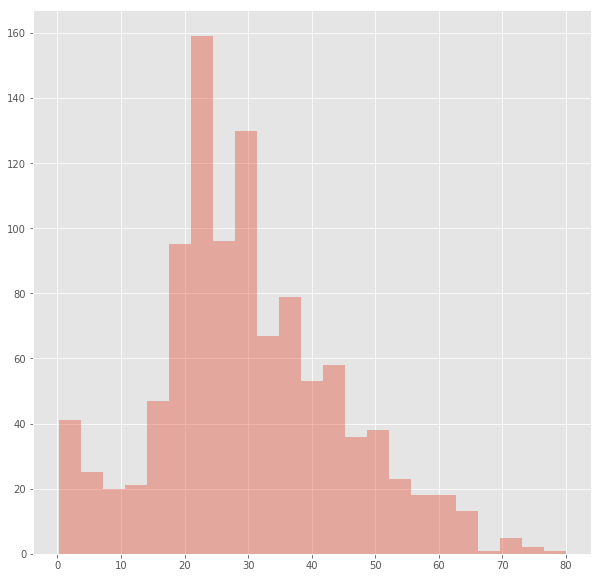

In [23]:
sns.distplot(full_data.loc[pd.notnull(full_data["Age"]),["Age"]],kde=False)

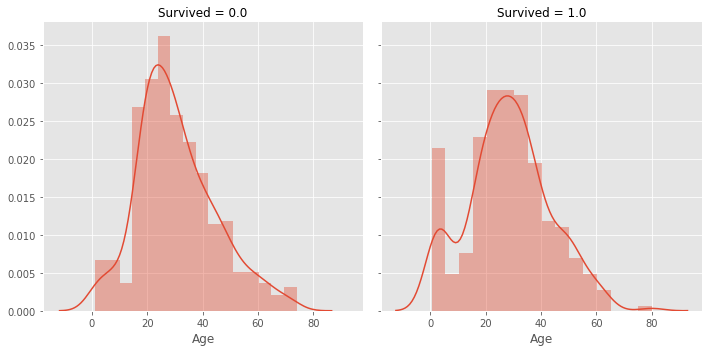

In [26]:
hist = sns.FacetGrid(full_data, col='Survived',size=5)
hist.map(sns.distplot,"Age")

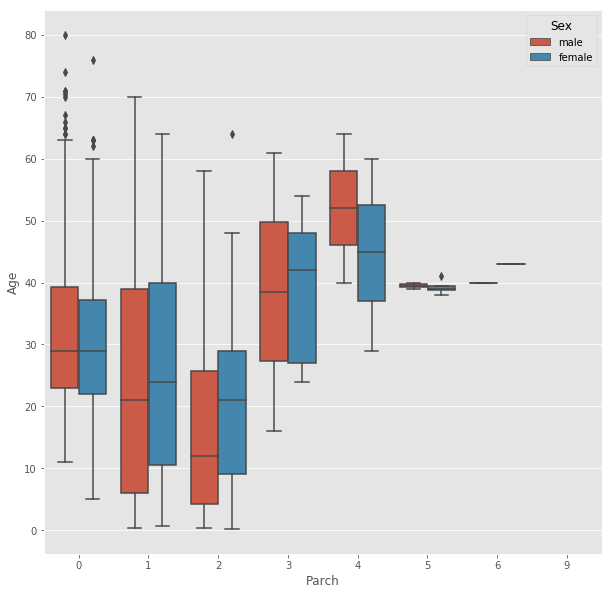

In [27]:
sns.boxplot(x="Parch",y="Age",hue="Sex",data=full_data)

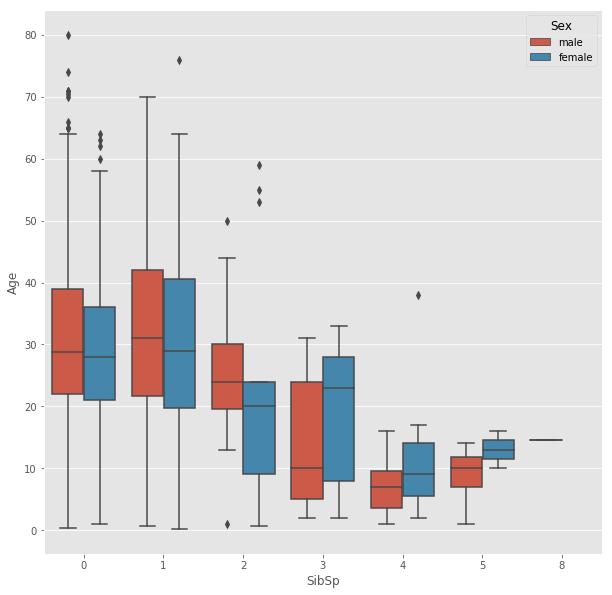

In [28]:
sns.boxplot(x="SibSp",y="Age",hue="Sex",data=full_data)

Lets Put our Tools to Work 

## Discrete Variables

### Survived 

In [29]:
full_data.groupby('Survived').describe().stack()

Age        Fare       Parch      Pclass       SibSp
Survived                                                                  
0.0      count  424.000000  549.000000  549.000000  549.000000  549.000000
         mean    30.626179   22.117887    0.329690    2.531876    0.553734
         std     14.172110   31.388207    0.823166    0.735805    1.288399
         min      1.000000    0.000000    0.000000    1.000000    0.000000
         25%     21.000000    7.854200    0.000000    2.000000    0.000000
         50%     28.000000   10.500000    0.000000    3.000000    0.000000
         75%     39.000000   26.000000    0.000000    3.000000    1.000000
         max     74.000000  263.000000    6.000000    3.000000    8.000000
1.0      count  290.000000  342.000000  342.000000  342.000000  342.000000
         mean    28.343690   48.395408    0.464912    1.950292    0.473684
         std     14.950952   66.596998    0.771712    0.863321    0.708688
         min      0.420000    0.000000    0.000000    1.000000    0.000000
         25%     19.000000   12.475000    0.000000    1.000000    0.000000
         50%     28.000000   26.000000    0.000000    2.000000    0.000000
         75%     36.000000   57.000000    1.000000    3.000000    1.000000
         max     80.000000  512.329200    5.000000    3.000000    4.000000

### Sex 

In [30]:
featureFamily = ['Sex']

response = 'Survived'

full_data[featureFamily+[response]].groupby(featureFamily).describe()

Survived                                             
          count      mean       std  min  25%  50%  75%  max
Sex                                                         
female    314.0  0.742038  0.438211  0.0  0.0  1.0  1.0  1.0
male      577.0  0.188908  0.391775  0.0  0.0  0.0  0.0  1.0

In [31]:
featureFamily = ['Sex']

response = 'Survived'

full_data[featureFamily+[response]].groupby(featureFamily).describe()

Survived                                             
          count      mean       std  min  25%  50%  75%  max
Sex                                                         
female    314.0  0.742038  0.438211  0.0  0.0  1.0  1.0  1.0
male      577.0  0.188908  0.391775  0.0  0.0  0.0  0.0  1.0

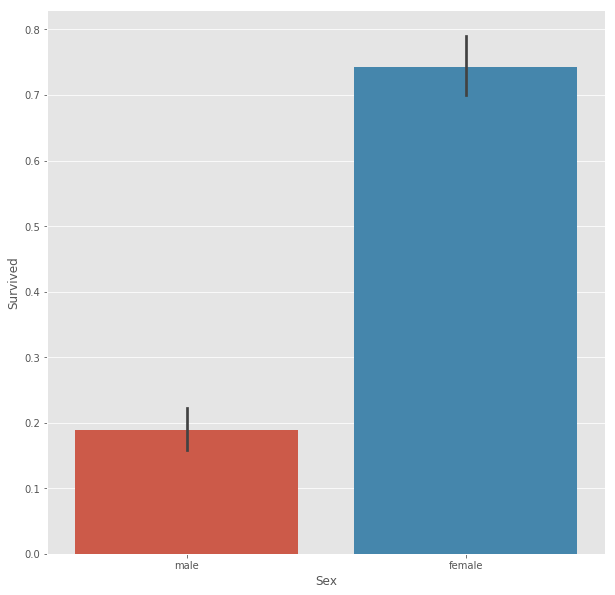

In [32]:
sns.barplot(x="Sex", y="Survived",data=full_data)

In [33]:
featureFamily = ['Sex','Embarked']

response = 'Survived'

full_data[featureFamily+[response]].groupby(featureFamily).describe()

Survived                                              
                   count      mean       std  min   25%  50%  75%  max
Sex    Embarked                                                       
female C            73.0  0.876712  0.331042  0.0  1.00  1.0  1.0  1.0
       Q            36.0  0.750000  0.439155  0.0  0.75  1.0  1.0  1.0
       S           203.0  0.689655  0.463778  0.0  0.00  1.0  1.0  1.0
male   C            95.0  0.305263  0.462962  0.0  0.00  0.0  1.0  1.0
       Q            41.0  0.073171  0.263652  0.0  0.00  0.0  0.0  1.0
       S           441.0  0.174603  0.380058  0.0  0.00  0.0  0.0  1.0

In [34]:
featureFamily = ['Sex','Pclass']

response = 'Survived'

full_data[featureFamily+[response]].groupby(featureFamily).describe()

Survived                                             
                 count      mean       std  min  25%  50%  75%  max
Sex    Pclass                                                      
female 1          94.0  0.968085  0.176716  0.0  1.0  1.0  1.0  1.0
       2          76.0  0.921053  0.271448  0.0  1.0  1.0  1.0  1.0
       3         144.0  0.500000  0.501745  0.0  0.0  0.5  1.0  1.0
male   1         122.0  0.368852  0.484484  0.0  0.0  0.0  1.0  1.0
       2         108.0  0.157407  0.365882  0.0  0.0  0.0  0.0  1.0
       3         347.0  0.135447  0.342694  0.0  0.0  0.0  0.0  1.0

### Class 

In [35]:
featureFamily = ['Pclass']

response = 'Survived'

full_data[featureFamily+[response]].groupby(featureFamily).describe()

Survived                                             
          count      mean       std  min  25%  50%  75%  max
Pclass                                                      
1         216.0  0.629630  0.484026  0.0  0.0  1.0  1.0  1.0
2         184.0  0.472826  0.500623  0.0  0.0  0.0  1.0  1.0
3         491.0  0.242363  0.428949  0.0  0.0  0.0  0.0  1.0

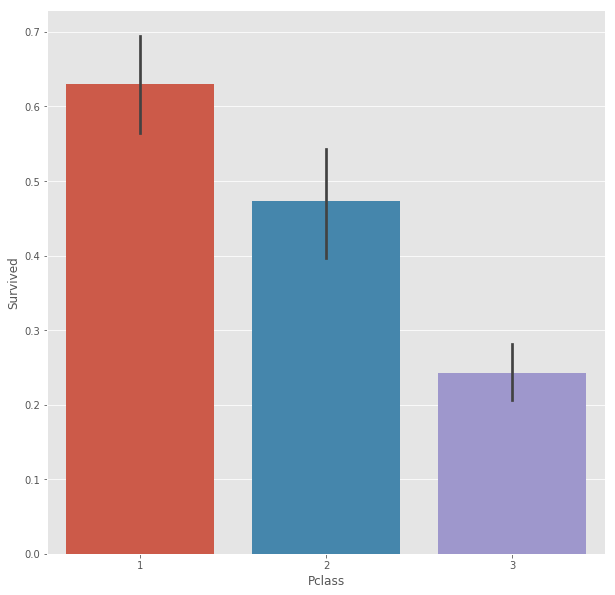

In [36]:
sns.barplot(x="Pclass", y="Survived", data=full_data)

In [37]:
featureFamily = ['Sex','Pclass']

response = 'Survived'

full_data[featureFamily+[response]].groupby(featureFamily).describe()

Survived                                             
                 count      mean       std  min  25%  50%  75%  max
Sex    Pclass                                                      
female 1          94.0  0.968085  0.176716  0.0  1.0  1.0  1.0  1.0
       2          76.0  0.921053  0.271448  0.0  1.0  1.0  1.0  1.0
       3         144.0  0.500000  0.501745  0.0  0.0  0.5  1.0  1.0
male   1         122.0  0.368852  0.484484  0.0  0.0  0.0  1.0  1.0
       2         108.0  0.157407  0.365882  0.0  0.0  0.0  0.0  1.0
       3         347.0  0.135447  0.342694  0.0  0.0  0.0  0.0  1.0

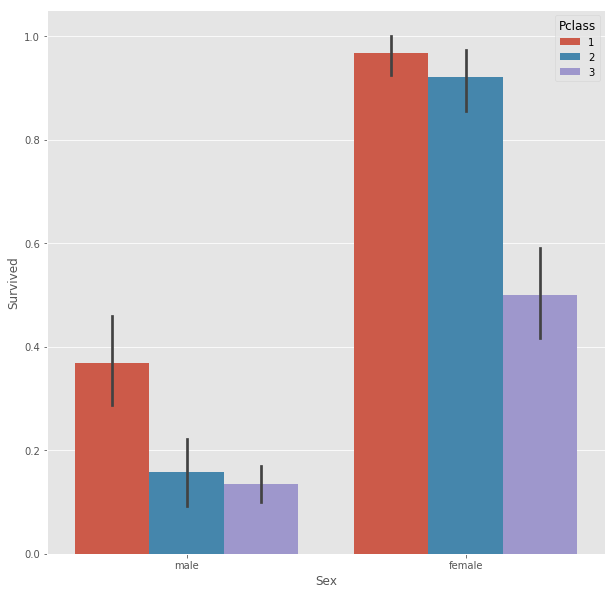

In [38]:
sns.barplot(x="Sex", y="Survived", hue="Pclass", data=full_data)

###  Embarked

In [110]:
HTML('<img src="https://media.giphy.com/media/11F0d3IVhQbreE/giphy.gif" width="400">')

###  Parch - Parents and Children

In [40]:
featureFamily = ['Parch']

response = 'Survived'

full_data[featureFamily+[response]].groupby(featureFamily).describe()

Survived                                             
         count      mean       std  min  25%  50%  75%  max
Parch                                                      
0        678.0  0.343658  0.475279  0.0  0.0  0.0  1.0  1.0
1        118.0  0.550847  0.499529  0.0  0.0  1.0  1.0  1.0
2         80.0  0.500000  0.503155  0.0  0.0  0.5  1.0  1.0
3          5.0  0.600000  0.547723  0.0  0.0  1.0  1.0  1.0
4          4.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
5          5.0  0.200000  0.447214  0.0  0.0  0.0  0.0  1.0
6          1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0
9          0.0       NaN       NaN  NaN  NaN  NaN  NaN  NaN

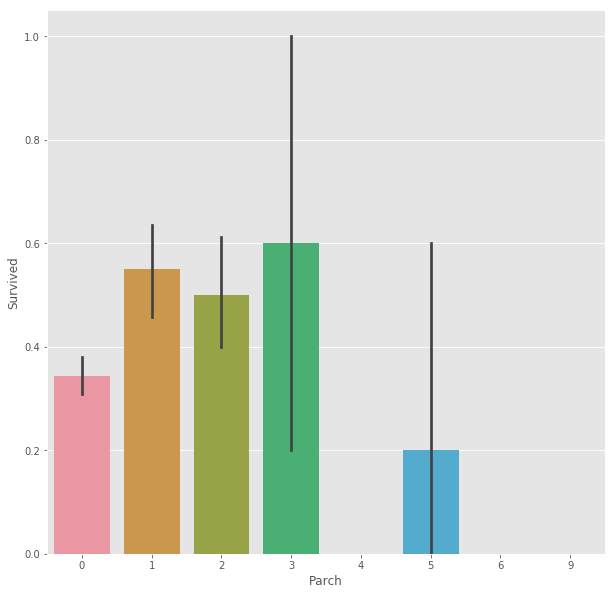

In [41]:
sns.barplot(x="Parch", y="Survived", data=full_data)

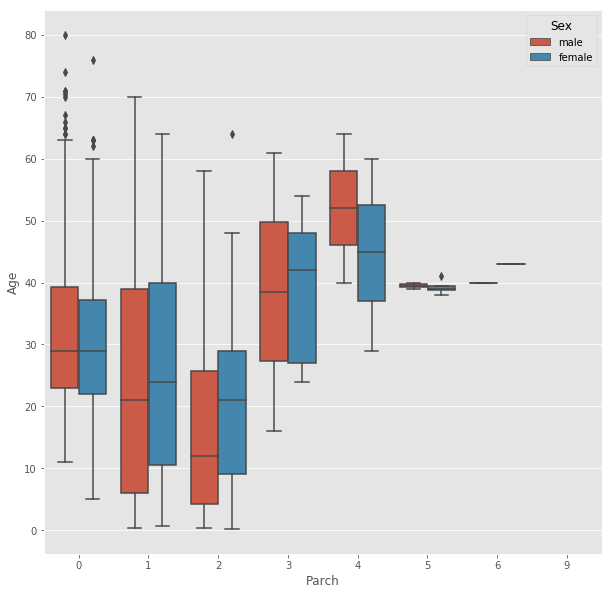

In [42]:
sns.boxplot(x="Parch",y="Age",hue="Sex",data=full_data)

### SibSp - Sibling or Spouse 

In [108]:
HTML('<img src="https://media.giphy.com/media/3oKIP9kbCldRMOb9KM/giphy.gif" width="500">')

## Continuous Variables 

<a id='to_fare_exp'></a>

### Fare

In [43]:
full_data["Fare"].describe()

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

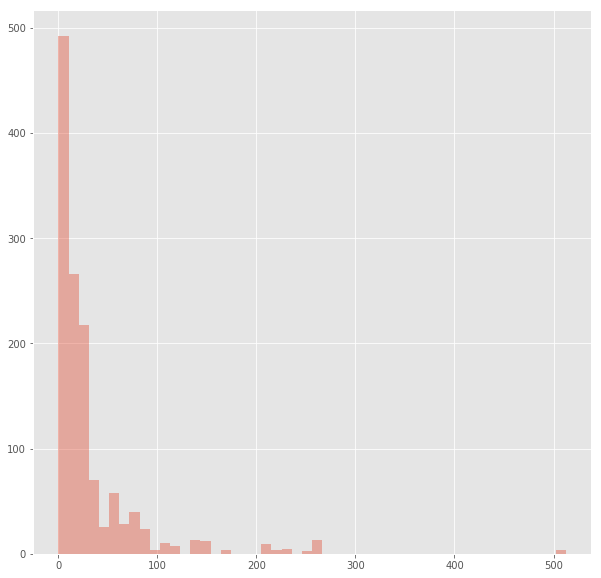

In [44]:
sns.distplot(full_data.loc[pd.notnull(full_data["Fare"]),["Fare"]],kde=False)

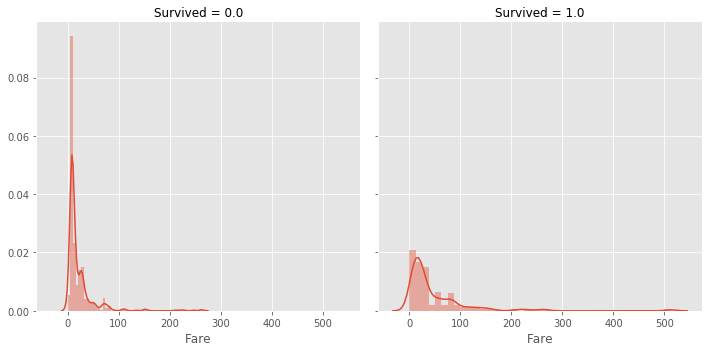

In [45]:
hist = sns.FacetGrid(full_data, col='Survived',size=5)
hist.map(sns.distplot,"Fare")

In [46]:
featureFamily = ['Pclass']

response = 'Fare'

full_data[featureFamily+[response]].groupby(featureFamily).describe()

Fare                                                                 
        count       mean        std  min      25%      50%       75%       max
Pclass                                                                        
1       323.0  87.508992  80.447178  0.0  30.6958  60.0000  107.6625  512.3292
2       277.0  21.179196  13.607122  0.0  13.0000  15.0458   26.0000   73.5000
3       708.0  13.302889  11.494358  0.0   7.7500   8.0500   15.2458   69.5500

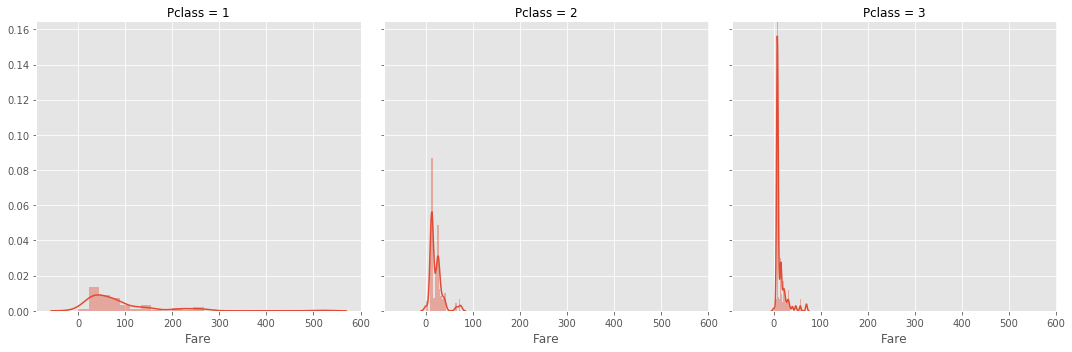

In [47]:
hist = sns.FacetGrid(full_data, col='Pclass', size=5)
hist.map(sns.distplot,"Fare")

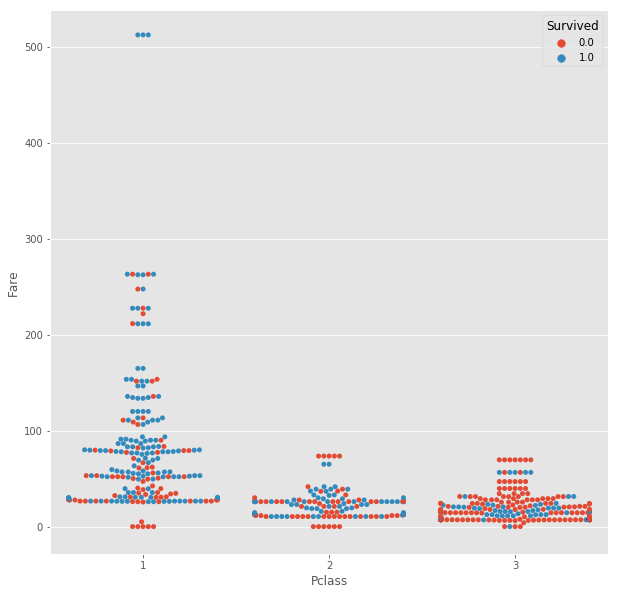

In [104]:
sns.swarmplot(x="Pclass",y="Fare",hue='Survived',data=full_data)

[Link to further work with Fare](#to_crew)

## Textual Variables 

### Name

In [49]:
full_data["Name"].head()

PassengerId
1                              Braund, Mr. Owen Harris
2    Cumings, Mrs. John Bradley (Florence Briggs Th...
3                               Heikkinen, Miss. Laina
4         Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                             Allen, Mr. William Henry
Name: Name, dtype: object

In [50]:
full_data["Name"].describe()

count                 1309
unique                1307
top       Kelly, Mr. James
freq                     2
Name: Name, dtype: object

### Cabin 

In [51]:
full_data["Cabin"].dropna().head()

PassengerId
2      C85
4     C123
7      E46
11      G6
12    C103
Name: Cabin, dtype: object

In [52]:
full_data["Cabin"].describe()

count             295
unique            186
top       C23 C25 C27
freq                6
Name: Cabin, dtype: object

In [73]:
full_data.groupby('Cabin').size().sort_values(ascending=False).head(10)

Cabin
C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
C78                4
F4                 4
F33                4
F2                 4
B96 B98            4
D                  4
C22 C26            4
dtype: int64

### Ticket

In [53]:
full_data["Ticket"].dropna().head()

PassengerId
1           A/5 21171
2            PC 17599
3    STON/O2. 3101282
4              113803
5              373450
Name: Ticket, dtype: object

In [54]:
full_data["Ticket"].describe()

count         1309
unique         929
top       CA. 2343
freq            11
Name: Ticket, dtype: object

In [74]:
full_data.groupby('Ticket').size().sort_values(ascending=False).head(10)

Ticket
CA. 2343        11
1601             8
CA 2144          8
S.O.C. 14879     7
PC 17608         7
347082           7
347077           7
3101295          7
382652           6
19950            6
dtype: int64

## Variable Dependence

### Correlation Matrix

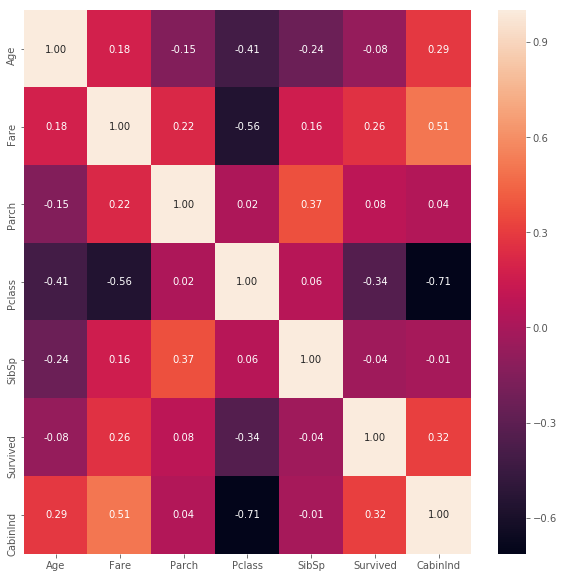

In [88]:
sns.heatmap(full_data.corr(), annot=True, fmt=".2f")

# Data Cleaning and Prep

## Missing Values Part 1

The way missing values are approached depends on many things:
 * Amount of missing values
 * Type of variable that includes missing values
  * Missing values may include information
 * Other available information
  * Substitute variables that don't have missing data
  * Variables that can help fill in missing data
 * Variable importance
 * How data was collected and what could have resulted in missing data

### Few Missing Values

* Replace every missing value with either the Median, Mode, Mean or some other simple function of the column
 * Could be specific to similar passengers
* Fit a statistical distribution to the known values of the column and then sample that distribution to replace missing values
* Drop records with missing data - Caution!

#### Fare

In [4]:
featureFamily = ['Pclass','Embarked']

response = 'Fare'

full_data[featureFamily+[response]].groupby(featureFamily).describe()

Fare                                                     \
                 count        mean        std      min       25%      50%   
Pclass Embarked                                                             
1      C         141.0  106.845330  96.837527  25.7417  49.50420  76.7292   
       Q           3.0   90.000000   0.000000  90.0000  90.00000  90.0000   
       S         177.0   72.148094  61.995107   0.0000  26.55000  52.0000   
2      C          28.0   23.300593  11.082198  12.0000  13.86145  15.3146   
       Q           7.0   11.735114   1.090680   9.6875  11.52915  12.3500   
       S         242.0   21.206921  13.969256   0.0000  13.00000  15.3750   
3      C         101.0   11.021624   4.862605   4.0125   7.22920   7.8958   
       Q         113.0   10.390820   6.040804   6.7500   7.75000   7.7500   
       S         494.0   14.435422  13.118281   0.0000   7.85420   8.0500   

                                      
                       75%       max  
Pclass Embarked                       
1      C         134.50000  512.3292  
       Q          90.00000   90.0000  
       S          83.47500  263.0000  
2      C          31.80415   41.5792  
       Q          12.35000   12.3500  
       S          26.00000   73.5000  
3      C          14.45830   22.3583  
       Q           7.87920   29.1250  
       S          15.90000   69.5500

In [100]:
# Show the rows with missing fare values
full_data[full_data['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
1044,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,3,male,0,NaN,3701


In [101]:
# Replace missing value with mean for that PClass and Embarked location
full_data.loc[full_data['Fare'].isnull(),['Fare']] = 14.43

#### Embarked 

In [107]:
HTML('<img src="http://cdn-wpmsa.defymedia.com/wp-content/uploads/sites/3/2014/05/modern-family-phil-gif.gif" width="500">')

### Many Missing Values

* Replace every missing value with either the Median, Mode, Mean or some other simple function of the column
* Fit a statistical distribution to the known values of the column and then sample that distribution to replace missing values
* Use additional features to construct missing data
* Transform variable
* Drop variables with a lot of missing data if it's not predictive - Caution!

#### Age 

In [6]:
full_data['Age'].describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

In [10]:
full_data[full_data['Age'].isnull()].head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
6,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,3,male,0,0.0,330877
18,NaN,NaN,S,13.0000,"Williams, Mr. Charles Eugene",0,2,male,0,1.0,244373
20,NaN,NaN,C,7.2250,"Masselmani, Mrs. Fatima",0,3,female,0,1.0,2649
27,NaN,NaN,C,7.2250,"Emir, Mr. Farred Chehab",0,3,male,0,0.0,2631
29,NaN,NaN,Q,7.8792,"O'Dwyer, Miss. Ellen ""Nellie""",0,3,female,0,1.0,330959


In [11]:
full_data['MissAge'] = 0
full_data.loc[full_data['Age'].isnull(),'MissAge'] = 1

In [15]:
featureFamily = ['MissAge','Embarked','Pclass']

response = 'Survived'

full_data[featureFamily+[response]].groupby(featureFamily).describe()

Survived                                            \
                           count      mean       std  min   25%  50%   75%   
MissAge Embarked Pclass                                                      
0       C        1          74.0  0.716216  0.453911  0.0  0.00  1.0  1.00   
                 2          15.0  0.533333  0.516398  0.0  0.00  1.0  1.00   
                 3          41.0  0.439024  0.502433  0.0  0.00  0.0  1.00   
        Q        1           2.0  0.500000  0.707107  0.0  0.25  0.5  0.75   
                 2           2.0  0.500000  0.707107  0.0  0.25  0.5  0.75   
                 3          24.0  0.250000  0.442326  0.0  0.00  0.0  0.25   
        S        1         108.0  0.611111  0.489771  0.0  0.00  1.0  1.00   
                 2         156.0  0.474359  0.500950  0.0  0.00  0.0  1.00   
                 3         290.0  0.210345  0.408258  0.0  0.00  0.0  0.00   
1       C        1          11.0  0.545455  0.522233  0.0  0.00  1.0  1.00   
                 2           2.0  0.500000  0.707107  0.0  0.25  0.5  0.75   
                 3          25.0  0.280000  0.458258  0.0  0.00  0.0  1.00   
        Q        2           1.0  1.000000       NaN  1.0  1.00  1.0  1.00   
                 3          48.0  0.437500  0.501328  0.0  0.00  0.0  1.00   
        S        1          19.0  0.421053  0.507257  0.0  0.00  0.0  1.00   
                 2           8.0  0.250000  0.462910  0.0  0.00  0.0  0.25   
                 3          63.0  0.095238  0.295901  0.0  0.00  0.0  0.00   

                              
                         max  
MissAge Embarked Pclass       
0       C        1       1.0  
                 2       1.0  
                 3       1.0  
        Q        1       1.0  
                 2       1.0  
                 3       1.0  
        S        1       1.0  
                 2       1.0  
                 3       1.0  
1       C        1       1.0  
                 2       1.0  
                 3       1.0  
        Q        2       1.0  
                 3       1.0  
        S        1       1.0  
                 2       1.0  
                 3       1.0

#### Cabin 

In [105]:
full_data['CabinInd'] = 1
full_data.loc[full_data['Cabin'].isnull(),'CabinInd'] = 0

In [106]:
featureFamily = ['CabinInd']

response = 'Survived'

full_data[featureFamily+[response]].groupby(featureFamily).describe()

Survived                                             
            count      mean       std  min  25%  50%  75%  max
CabinInd                                                      
0           687.0  0.299854  0.458528  0.0  0.0  0.0  1.0  1.0
1           204.0  0.666667  0.472564  0.0  0.0  1.0  1.0  1.0

In [107]:
featureFamily = ['CabinInd','Pclass']

response = 'Survived'

full_data[featureFamily+[response]].groupby(featureFamily).describe()

Survived                                             
                   count      mean       std  min  25%  50%  75%  max
CabinInd Pclass                                                      
0        1          40.0  0.475000  0.505736  0.0  0.0  0.0  1.0  1.0
         2         168.0  0.440476  0.497928  0.0  0.0  0.0  1.0  1.0
         3         479.0  0.235908  0.425009  0.0  0.0  0.0  0.0  1.0
1        1         176.0  0.664773  0.473417  0.0  0.0  1.0  1.0  1.0
         2          16.0  0.812500  0.403113  0.0  1.0  1.0  1.0  1.0
         3          12.0  0.500000  0.522233  0.0  0.0  0.5  1.0  1.0

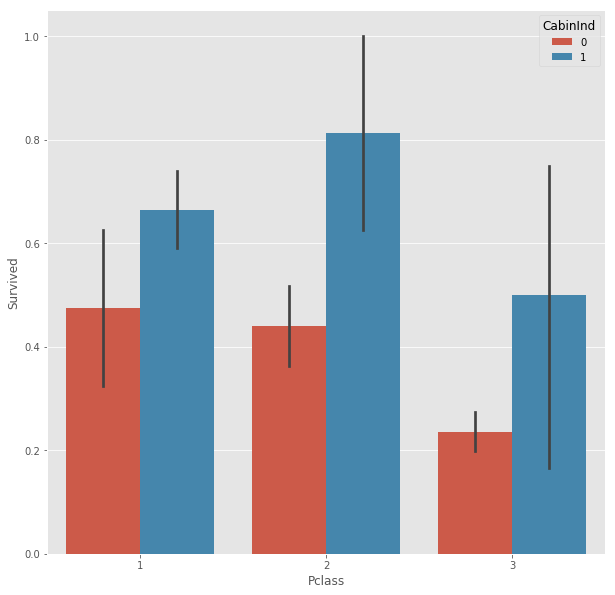

In [87]:
sns.barplot(x="Pclass", y="Survived", hue="CabinInd", data=full_data)

## Creating New Features

### Modifying Existing Features

#### Pclass 

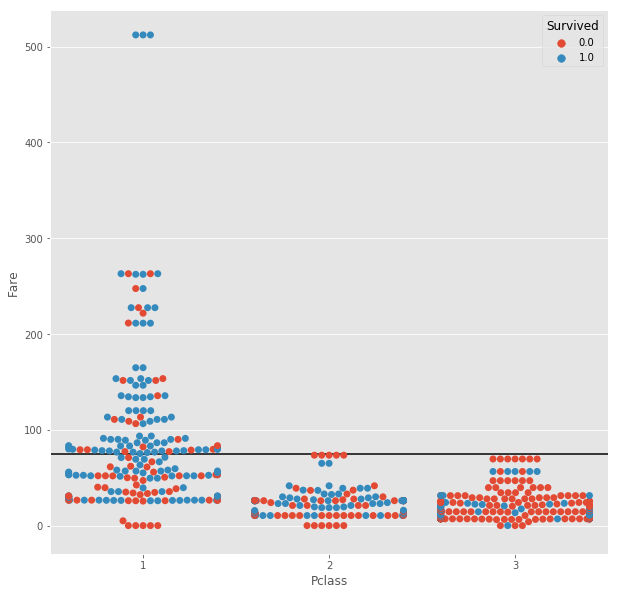

In [48]:
sns.swarmplot(x="Pclass",y="Fare",hue="Survived",data=full_data, size=7)

x = plt.gca().axes.get_xlim()

plt.plot(x, len(x) * [75], sns.xkcd_rgb["black"])
plt.show()

In [108]:
# increase all class values by one to add a new highest class
full_data['Mod_Class'] = full_data.Pclass + 1

# passengers that paid more than $75 are in their own class
full_data.loc[full_data.Fare >= 75,'Mod_Class'] = 1

# look at the counts
full_data['Mod_Class'].value_counts()

4    709
3    277
2    178
1    145
Name: Mod_Class, dtype: int64

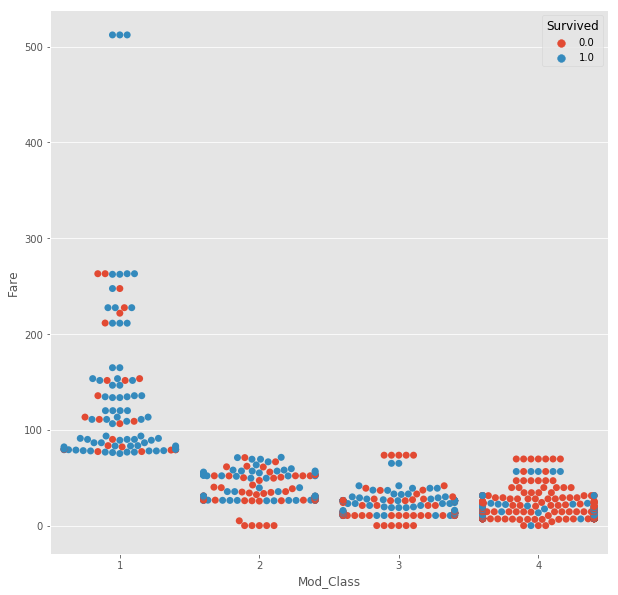

In [91]:
sns.swarmplot(x="Mod_Class",y="Fare",hue="Survived",data=full_data, size=7)

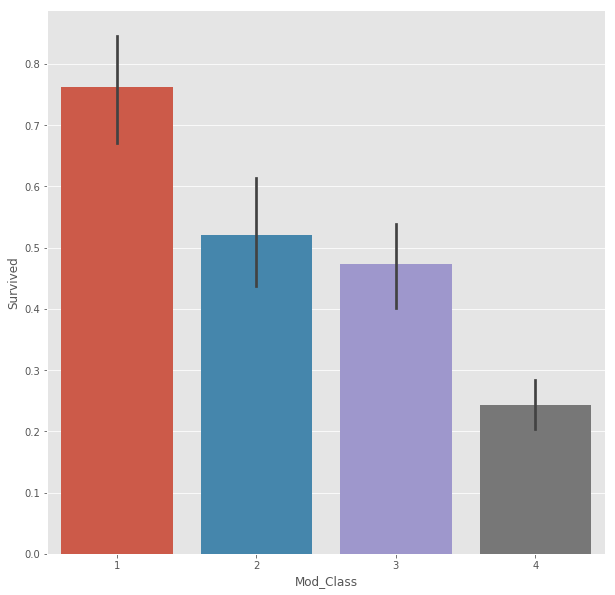

In [37]:
sns.barplot(x="Mod_Class", y="Survived", data=full_data)

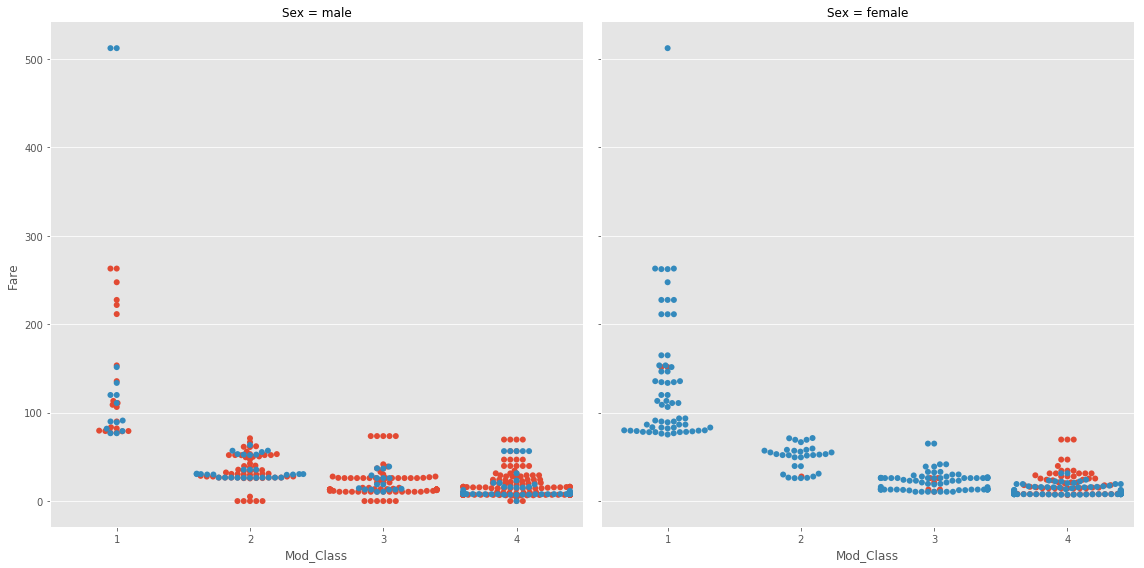

In [31]:
g = sns.FacetGrid(full_data, col='Sex',hue="Survived",size=8)
g = g.map(sns.swarmplot,"Mod_Class","Fare",order=[1,2,3,4], size=6)

### Extracting From Other Features 

In [86]:
full_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,MissAge,Mod_Class,Deck
PassengerId,,,,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,0,4,NaN
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599,0,2,C
3,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,0,4,NaN
4,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,0,2,C
5,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,0,4,NaN


#### Deck from Cabin

In [109]:
full_data['Deck'] = full_data['Cabin'].str[0]

In [110]:
featureFamily = ['Deck']

response = 'Survived'

full_data[featureFamily+[response]].groupby(featureFamily).describe()

Survived                                              
        count      mean       std  min   25%  50%  75%  max
Deck                                                       
A        15.0  0.466667  0.516398  0.0  0.00  0.0  1.0  1.0
B        47.0  0.744681  0.440755  0.0  0.50  1.0  1.0  1.0
C        59.0  0.593220  0.495450  0.0  0.00  1.0  1.0  1.0
D        33.0  0.757576  0.435194  0.0  1.00  1.0  1.0  1.0
E        32.0  0.750000  0.439941  0.0  0.75  1.0  1.0  1.0
F        13.0  0.615385  0.506370  0.0  0.00  1.0  1.0  1.0
G         4.0  0.500000  0.577350  0.0  0.00  0.5  1.0  1.0
T         1.0  0.000000       NaN  0.0  0.00  0.0  0.0  0.0

In [114]:
# replace very samll Deck groups with other
full_data.loc[full_data['Deck'] == 'G','Deck'] = 'OTHER'
full_data.loc[full_data['Deck'] == 'T','Deck'] = 'OTHER'

# set missing cabins to other, other will mostly represent no cabin
full_data.loc[full_data['Deck'].isnull(),'Deck'] = 'OTHER'

In [115]:
featureFamily = ['CabinInd','Mod_Class']

response = 'Survived'

full_data[featureFamily+[response]].groupby(featureFamily).describe()

Survived                                             
                      count      mean       std  min  25%  50%  75%  max
CabinInd Mod_Class                                                      
0        1             14.0  0.785714  0.425815  0.0  1.0  1.0  1.0  1.0
         2             26.0  0.307692  0.470679  0.0  0.0  0.0  1.0  1.0
         3            168.0  0.440476  0.497928  0.0  0.0  0.0  1.0  1.0
         4            479.0  0.235908  0.425009  0.0  0.0  0.0  0.0  1.0
1        1             83.0  0.759036  0.430268  0.0  1.0  1.0  1.0  1.0
         2             93.0  0.580645  0.496128  0.0  0.0  1.0  1.0  1.0
         3             16.0  0.812500  0.403113  0.0  1.0  1.0  1.0  1.0
         4             12.0  0.500000  0.522233  0.0  0.0  0.5  1.0  1.0

In [116]:
featureFamily = ['Mod_Class','Deck']

response = 'Survived'

full_data[featureFamily+[response]].groupby(featureFamily).describe()

Survived                                              
                   count      mean       std  min   25%  50%  75%  max
Mod_Class Deck                                                        
1         A          1.0  1.000000       NaN  1.0  1.00  1.0  1.0  1.0
          B         27.0  0.888889  0.320256  0.0  1.00  1.0  1.0  1.0
          C         34.0  0.617647  0.493270  0.0  0.00  1.0  1.0  1.0
          D         15.0  0.800000  0.414039  0.0  1.00  1.0  1.0  1.0
          E          6.0  0.833333  0.408248  0.0  1.00  1.0  1.0  1.0
          OTHER     14.0  0.785714  0.425815  0.0  1.00  1.0  1.0  1.0
2         A         14.0  0.428571  0.513553  0.0  0.00  0.0  1.0  1.0
          B         20.0  0.550000  0.510418  0.0  0.00  1.0  1.0  1.0
          C         25.0  0.560000  0.506623  0.0  0.00  1.0  1.0  1.0
          D         14.0  0.714286  0.468807  0.0  0.25  1.0  1.0  1.0
          E         19.0  0.684211  0.477567  0.0  0.00  1.0  1.0  1.0
          OTHER     27.0  0.296296  0.465322  0.0  0.00  0.0  1.0  1.0
3         D          4.0  0.750000  0.500000  0.0  0.75  1.0  1.0  1.0
          E          4.0  0.750000  0.500000  0.0  0.75  1.0  1.0  1.0
          F          8.0  0.875000  0.353553  0.0  1.00  1.0  1.0  1.0
          OTHER    168.0  0.440476  0.497928  0.0  0.00  0.0  1.0  1.0
4         E          3.0  1.000000  0.000000  1.0  1.00  1.0  1.0  1.0
          F          5.0  0.200000  0.447214  0.0  0.00  0.0  0.0  1.0
          OTHER    483.0  0.238095  0.426359  0.0  0.00  0.0  0.0  1.0

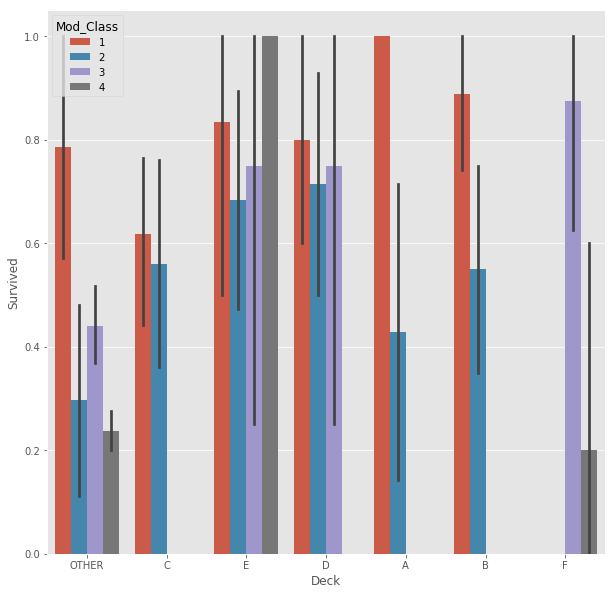

In [97]:
sns.barplot(x='Deck',y='Survived',hue='Mod_Class',data=full_data)

#### Name 

In [106]:
HTML('<img src="https://media.giphy.com/media/g9582DNuQppxC/giphy.gif" width="500">')

<a id='to_age_gp'></a>

#### Age Group from Age


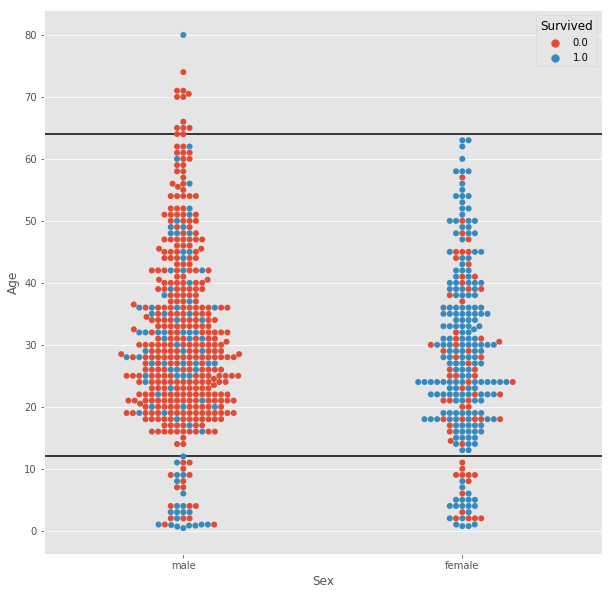

In [126]:
sns.swarmplot(x="Sex",y="Age",hue='Survived',data=full_data,size=6)

x = plt.gca().axes.get_xlim()


plt.plot(x, len(x) * [12], sns.xkcd_rgb["black"])
plt.plot(x, len(x) * [64], sns.xkcd_rgb["black"])
plt.show()

In [127]:
full_data['AgeGroup'] = np.where(full_data['Age'] < 12, 'Child',
                            np.where(full_data['Age'] > 64,'Senior',
                                     (np.where((full_data['Age'].isnull()),'Missing',
                                     'Adult'))))

In [128]:
featureFamily = ['AgeGroup']

response = 'Survived'

full_data[featureFamily+[response]].groupby(featureFamily).describe()

Survived                                             
            count      mean       std  min  25%  50%  75%  max
AgeGroup                                                      
Adult       635.0  0.393701  0.488955  0.0  0.0  0.0  1.0  1.0
Child        68.0  0.573529  0.498241  0.0  0.0  1.0  1.0  1.0
Missing     177.0  0.293785  0.456787  0.0  0.0  0.0  1.0  1.0
Senior       11.0  0.090909  0.301511  0.0  0.0  0.0  0.0  1.0

Records with Missing ages appear to have lower survival rates than children and adults, it could be that they are of lower class.

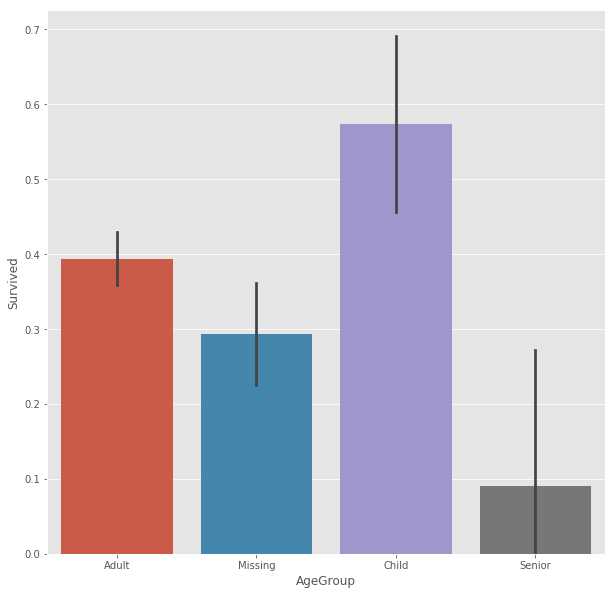

In [87]:
sns.barplot(x='AgeGroup',y='Survived',data=full_data)

In [129]:
featureFamily = ['AgeGroup','Mod_Class']

response = 'Survived'

full_data[featureFamily+[response]].groupby(featureFamily).describe()

Survived                                               
                      count      mean       std  min   25%  50%   75%  max
AgeGroup Mod_Class                                                        
Adult    1             85.0  0.764706  0.426700  0.0  1.00  1.0  1.00  1.0
         2             91.0  0.582418  0.495893  0.0  0.00  1.0  1.00  1.0
         3            154.0  0.428571  0.496486  0.0  0.00  0.0  1.00  1.0
         4            305.0  0.216393  0.412462  0.0  0.00  0.0  0.00  1.0
Child    1              4.0  0.750000  0.500000  0.0  0.75  1.0  1.00  1.0
         3             17.0  1.000000  0.000000  1.0  1.00  1.0  1.00  1.0
         4             47.0  0.404255  0.496053  0.0  0.00  0.0  1.00  1.0
Missing  1              8.0  0.750000  0.462910  0.0  0.75  1.0  1.00  1.0
         2             22.0  0.363636  0.492366  0.0  0.00  0.0  1.00  1.0
         3             11.0  0.363636  0.504525  0.0  0.00  0.0  1.00  1.0
         4            136.0  0.250000  0.434613  0.0  0.00  0.0  0.25  1.0
Senior   1              0.0       NaN       NaN  NaN   NaN  NaN   NaN  NaN
         2              6.0  0.166667  0.408248  0.0  0.00  0.0  0.00  1.0
         3              2.0  0.000000  0.000000  0.0  0.00  0.0  0.00  0.0
         4              3.0  0.000000  0.000000  0.0  0.00  0.0  0.00  0.0

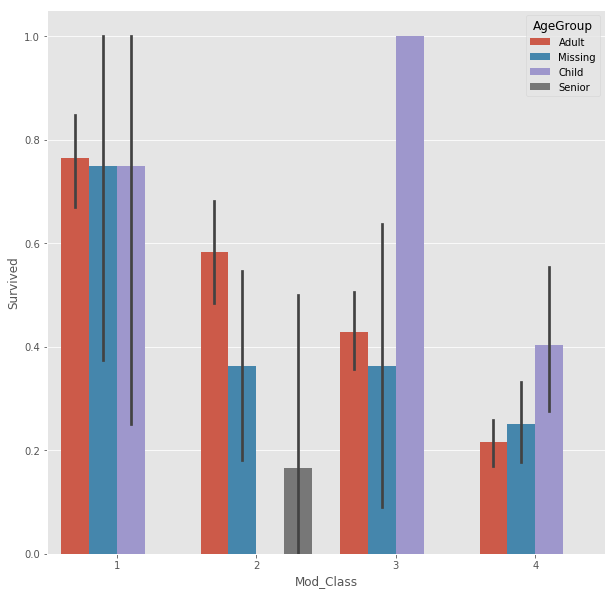

In [99]:
sns.barplot(x='Mod_Class',y='Survived',hue="AgeGroup",data=full_data)

That appears to be it.  It also looks like most children are in the lowest class.

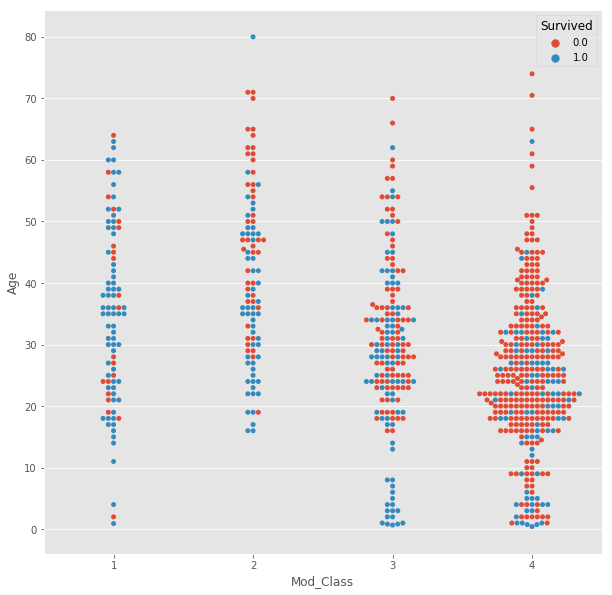

In [130]:
sns.swarmplot(x="Mod_Class",y="Age",hue='Survived',data=full_data)

Lets see if most children boarded the ship from one port.

In [100]:
featureFamily = ['AgeGroup','Embarked']

response = 'Survived'

full_data[featureFamily+[response]].groupby(featureFamily).describe()

Survived                                             
                     count      mean       std  min  25%  50%  75%  max
AgeGroup Embarked                                                      
Adult    C           117.0  0.606838  0.490553  0.0  0.0  1.0  1.0  1.0
         Q            22.0  0.363636  0.492366  0.0  0.0  0.0  1.0  1.0
         S           494.0  0.342105  0.474896  0.0  0.0  0.0  1.0  1.0
Child    C            10.0  0.800000  0.421637  0.0  1.0  1.0  1.0  1.0
         Q             4.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
         S            54.0  0.574074  0.499126  0.0  0.0  1.0  1.0  1.0
Missing  C            38.0  0.368421  0.488852  0.0  0.0  0.0  1.0  1.0
         Q            49.0  0.448980  0.502545  0.0  0.0  0.0  1.0  1.0
         S            90.0  0.177778  0.384467  0.0  0.0  0.0  0.0  1.0
Senior   C             3.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
         Q             2.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
         S             6.0  0.166667  0.408248  0.0  0.0  0.0  0.0  1.0

Yes! Most children (and their parents hopefully) embarked in Southampton

We've gotten a good list variables that appeared to be tied to age:
 * Embarked
 * Class
 * Prefix
 * SibSp
 * ParCh
 
We can use these variables to fill in missing age data.  We will do this a little later. ([Link to later](#to_age_gp_pred))

#### Fare

In [105]:
HTML('<img src="https://media.giphy.com/media/BtedgmzGNCiuk/giphy.gif" width="500">')

[Link back to exploration of Fare](#to_fare_exp)

<a id='to_comb_ftrs'></a>

### Combining Multiple Features 

#### Family Size 

In [132]:
# Family size is just combining both features
full_data['FamSize'] = full_data.SibSp + full_data.Parch

# Alone is 1 if a person was alone on the ship and 0 otherwise
full_data['Alone'] = 1
full_data.loc[(full_data.SibSp + full_data.Parch) > 0, ['Alone']] = 0

full_data['Alone'].value_counts()

1    790
0    519
Name: Alone, dtype: int64

In [133]:
featureFamily = ['Alone']

response = 'Survived'

full_data[featureFamily+[response]].groupby(featureFamily).describe()

Survived                                             
         count      mean       std  min  25%  50%  75%  max
Alone                                                      
0        354.0  0.505650  0.500676  0.0  0.0  1.0  1.0  1.0
1        537.0  0.303538  0.460214  0.0  0.0  0.0  1.0  1.0

In [88]:
featureFamily = ['FamSize']

response = 'Survived'

full_data[featureFamily+[response]].groupby(featureFamily).describe()

Survived                                             
           count      mean       std  min  25%  50%  75%  max
FamSize                                                      
0          537.0  0.303538  0.460214  0.0  0.0  0.0  1.0  1.0
1          161.0  0.552795  0.498756  0.0  0.0  1.0  1.0  1.0
2          102.0  0.578431  0.496249  0.0  0.0  1.0  1.0  1.0
3           29.0  0.724138  0.454859  0.0  0.0  1.0  1.0  1.0
4           15.0  0.200000  0.414039  0.0  0.0  0.0  0.0  1.0
5           22.0  0.136364  0.351250  0.0  0.0  0.0  0.0  1.0
6           12.0  0.333333  0.492366  0.0  0.0  0.0  1.0  1.0
7            6.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
10           7.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

<a id='to_text_ftr'></a>

### Textual Features

#### Ticket

In [24]:
HTML('<img src="https://media.giphy.com/media/U86dK3B1QK7eg/giphy.gif" width="300">')

In [134]:
featureFamily = ['Ticket']

response = 'FamSize'

full_data[featureFamily+[response]].groupby(featureFamily).describe().sort_values(by=('FamSize','count'), ascending=False).head(10)

FamSize                                                    
               count       mean       std   min    25%   50%   75%   max
Ticket                                                                  
CA. 2343        11.0  10.000000  0.000000  10.0  10.00  10.0  10.0  10.0
1601             8.0   0.000000  0.000000   0.0   0.00   0.0   0.0   0.0
CA 2144          8.0   7.000000  0.000000   7.0   7.00   7.0   7.0   7.0
3101295          7.0   4.285714  1.889822   0.0   5.00   5.0   5.0   5.0
347077           7.0   6.000000  0.000000   6.0   6.00   6.0   6.0   6.0
347082           7.0   6.000000  0.000000   6.0   6.00   6.0   6.0   6.0
S.O.C. 14879     7.0   0.857143  1.069045   0.0   0.00   0.0   2.0   2.0
PC 17608         7.0   2.857143  1.951800   0.0   2.00   4.0   4.0   4.0
19950            6.0   5.000000  0.000000   5.0   5.00   5.0   5.0   5.0
113781           6.0   2.000000  1.549193   0.0   0.75   3.0   3.0   3.0

<a id='to_names'></a>

#### Last Name

In [62]:
full_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,CabinInd,Mod_Class,Deck,FamName,RawPfx,Pfx,FamSize,Alone,FamNameNotSur
PassengerId,,,,,,,,,,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,0,4,OTHER,Braund,Mr,Mr,1,0,0
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599,1,2,C,Cumings,Mrs,Mrs,1,0,0
3,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,0,4,OTHER,Heikkinen,Miss,Miss,0,1,0
4,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,1,2,C,Futrelle,Mrs,Mrs,1,0,0
5,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,0,4,OTHER,Allen,Mr,Mr,0,1,0


In [140]:
un_names_train = pd.DataFrame(full_data[full_data['Survived'].notnull()].FamName.unique(), columns = ['FamName'])

un_names_train.shape

(667, 1)

In [141]:
un_names_test =pd.DataFrame(full_data[full_data['Survived'].isna()].FamName.unique(), columns = ['FamName'])

un_names_test.shape

(352, 1)

In [142]:
pd.merge(un_names_train, un_names_test, on =['FamName','FamName']).shape

(144, 1)

 * 144 family names are shared between both datasets
 * I want to create some features to capture records that have survived/not survived family members
 * The features will be pretty simple
 * FamNameNotSur is set to 1 if at least one person with the same last name was marked as not survived, and 0 otherwise
 * I excluded passengers that were alone because any last name matches for them are by pure chance
 * Classifying training and testing records as FamNameNotSur was slightly different, because in the training dataset every non-survived record will match at least once (to itself)
 * That is not the case for the test set because the survived values are missing

In [143]:
# Get list of passangers that survived and had some family on the Titanic
sur = full_data.loc[(full_data.Alone > 0) & (full_data.Survived == 1)].FamName

# Get list of passangers that did not survive and had some family on the Titanic
non_sur = full_data.loc[(full_data.Alone > 0) & (full_data.Survived == 0)].FamName

# Count number of passangers with each last name that didn't survive
non_sur_cts = non_sur.value_counts()

# set to 0
full_data['FamNameNotSur'] = 0

# update FamNotSur values for passengers that had some family on the ship
# and had at least one other person with the same last name that did not survive
full_data.loc[(full_data.Alone > 0) & (full_data[full_data['Survived'].notnull()].FamName.isin(non_sur_cts[non_sur_cts > 1].index)),'FamNameNotSur'] = 1
full_data.loc[(full_data.Alone > 0) & (full_data[full_data['Survived'].isna()].FamName.isin(non_sur_cts.index)),'FamNameNotSur'] = 1

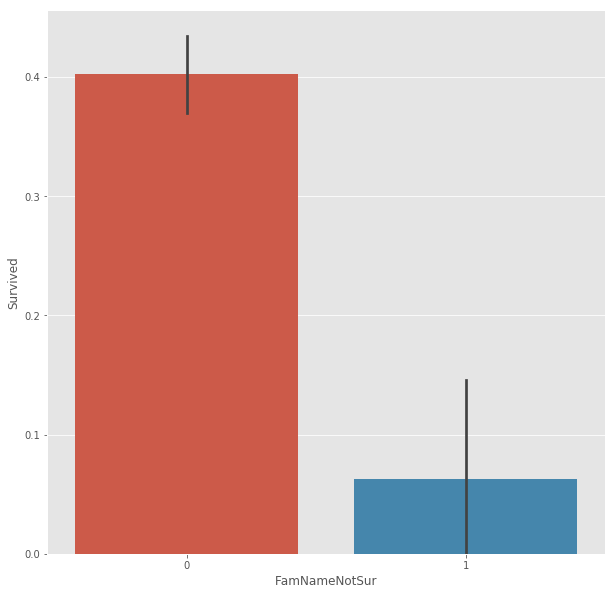

In [144]:
matplotlib.rcParams['figure.figsize'] = (10,10)
sns.barplot(x="FamNameNotSur", y="Survived", data=full_data)

## Appendix 

<a id='to_crew'></a>

[Link to more features](#to_comb_ftrs)

# Save/Reload Checkpoint 

## Save

In [145]:
pickle.dump(full_data, open("full_data_bkp.p", "wb"))

## Reload

In [187]:
full_data = pickle.load(open("full_data_bkp.p", "rb" ))

In [188]:
full_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,...,Deck,FamName,RawPfx,Pfx,AgeGroup,Crew,FamSize,Alone,TicketNotSur,FamNameNotSur
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,...,OTHER,Braund,Mr,Mr,Adult,0,1,0,0,0
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,...,C,Cumings,Mrs,Mrs,Adult,0,1,0,0,0
3,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,...,OTHER,Heikkinen,Miss,Miss,Adult,0,0,1,0,0
4,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,...,C,Futrelle,Mrs,Mrs,Adult,0,1,0,0,0
5,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,...,OTHER,Allen,Mr,Mr,Adult,0,0,1,0,0


# Model Dataset Preparation 

##  Ordinal vs Non-Ordinal Categorical Variables

Categorical variables need to be represented by integer values before being fed into SciKit Learn's Models
 * Ordinal Variables
  * Can be represented by simple integer encoding as long as the order is correct
  * Example: Age Group
 * Non-Ordinal Variables
  * Should be represented by boolean flags
  * Example: Embarked location
  * Warning: This will increase your variable count

In [40]:
full_data.dtypes

Age          float64
Cabin         object
Embarked      object
Fare         float64
Name          object
Parch          int64
Pclass         int64
Sex           object
SibSp          int64
Survived     float64
Ticket        object
Mod_Class      int64
Deck          object
CabinInd       int64
FamName       object
RawPfx        object
AgeGroup      object
dtype: object

Our ordinal categorical variable is age group. Deck may have some order to it, but it didn't seem to impact survival in any significant way, so we won't introduce an order. We have a lot of non ordinal categorical variables that need to be encoded.

__Wait!! We still have missing values!__

## Predicting Age Group - Dataset Preparation

### Convert Age Group to an Integer

In [189]:
AgeGpMap = {'Child' : 0, 'Adult' : 1, 'Senior' : 2, 'Missing' : 3} #Create a mapping

full_data['AgeGpIntRaw'] = full_data['AgeGroup'].map(AgeGpMap) 

full_data.groupby('AgeGpIntRaw').size() 

AgeGpIntRaw
0     91
1    942
2     13
3    263
dtype: int64

List of non-ordinal categorical variables that need to be encoded

In [190]:
age_cvar = ['Embarked','Pfx']

List of variables we will be using to predict the Age Group that we picked earlier ([Link back to Age Group](#to_age_gp))

<a id='to_age_gp_pred'></a>

###  Form Datasets

In [191]:
pred_lst = ['Embarked','Pfx','Mod_Class','Parch','SibSp']

In [192]:
age_pred = [c for c in pred_lst if c not in age_cvar]
for cat in age_cvar:
    age_pred.append("C({})".format(cat))

In [193]:
model_string = 'AgeGpIntRaw ~ -1 + ' + reduce(lambda x,y: str(x)+" + "+str(y), age_pred)
print(model_string)
%time Y_age, X_age = patsy.dmatrices(model_string, full_data, return_type='dataframe')

AgeGpIntRaw ~ -1 + Mod_Class + Parch + SibSp + C(Embarked) + C(Pfx)
CPU times: user 16.2 ms, sys: 2.31 ms, total: 18.5 ms
Wall time: 16.5 ms


In [68]:
X_age.head()

,C(Embarked)[C],C(Embarked)[Q],C(Embarked)[S],C(Pfx)[T.Miss],C(Pfx)[T.Mr],C(Pfx)[T.Mrs],C(Pfx)[T.Rev],Mod_Class,Parch,SibSp
PassengerId,,,,,,,,,,
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0
5,0.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0


In [52]:
Y_age.head()

,AgeGpIntRaw
PassengerId,
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0


### Split Training and Predicting Sets

In [194]:
X_age_train = X_age.loc[full_data['AgeGroup'] != 'Missing']
Y_age_train = Y_age.loc[full_data['AgeGroup'] != 'Missing']

X_age_pred = X_age.loc[full_data['AgeGroup'] == 'Missing']
Y_age_pred = Y_age.loc[full_data['AgeGroup'] == 'Missing']

In [195]:
print("Predicting set size:")
print(X_age_train.index.size)

print("Train set size:")
print(X_age_pred.index.size)

print("Predicting to training ratio")
print(round(X_age_pred.index.size/X_age_train.index.size, 2))

Predicting set size:
1046
Train set size:
263
Predicting to training ratio
0.25


[Link to Age Group Model](#to_age_gp_mdl)

<a id='to_mdl_prp'></a>

## Prepare Dataset for Survival Prediction 

In [90]:
full_data.dtypes

Age                      float64
Cabin                     object
Embarked                  object
Fare                     float64
Name                      object
Parch                      int64
Pclass                     int64
Sex                       object
SibSp                      int64
Survived                 float64
Ticket                    object
CabinInd                   int64
Deck                      object
FamName                   object
RawPfx                    object
Pfx                       object
AgeGroup                  object
Crew                       int64
AgeGpIntRaw                int64
Mod_Class                  int64
pessimisticPrediction      int64
FamSize                    int64
Alone                      int64
dtype: object

In [201]:
# Need to modify predicted variable to work with patsy
full_data['ModSurv'] = full_data['Survived']

full_data.loc[full_data['Survived'].isna(),'ModSurv'] = 2

In [202]:
# List of categorical variables that need to be encoded
cat_var = ['Embarked','Sex','Deck','Pfx','PrdAgeGp']

### Get List of Features for Modeling

In [296]:
# list of all predictors for survival
pred_lst = ['Embarked','Fare','CabinInd','Deck','Pfx','Sex','Crew','PrdAgeGp','Mod_Class','FamSize','Alone','TicketNotSur','FamNameNotSur']

In [297]:
age_pred = [c for c in pred_lst if c not in age_cvar]
for cat in age_cvar:
    age_pred.append("C({})".format(cat))

In [298]:
## Create dataset for regressions
model_string_reg = 'ModSurv ~' + reduce(lambda x,y: str(x)+" + "+str(y), pred_lst)
print(model_string_reg)
%time Y_reg, X_reg = patsy.dmatrices(model_string_reg, full_data, return_type='dataframe')

ModSurv ~Embarked + Fare + CabinInd + Deck + Pfx + Sex + Crew + PrdAgeGp + Mod_Class + FamSize + Alone + TicketNotSur + FamNameNotSur
CPU times: user 35.6 ms, sys: 2.45 ms, total: 38.1 ms
Wall time: 35.8 ms


In [299]:
## Create dataset for all other models
model_string = 'ModSurv ~ -1 + ' + reduce(lambda x,y: str(x)+" + "+str(y), pred_lst)
print(model_string)
%time Y, X = patsy.dmatrices(model_string, full_data, return_type='dataframe')

ModSurv ~ -1 + Embarked + Fare + CabinInd + Deck + Pfx + Sex + Crew + PrdAgeGp + Mod_Class + FamSize + Alone + TicketNotSur + FamNameNotSur
CPU times: user 34.5 ms, sys: 2.77 ms, total: 37.3 ms
Wall time: 34.8 ms


In [288]:
X.head()

,Embarked[C],Embarked[Q],Embarked[S],Deck[T.B],Deck[T.C],Deck[T.D],Deck[T.E],Deck[T.F],Deck[T.OTHER],Pfx[T.Miss],...,Pfx[T.Rev],Sex[T.male],PrdAgeGp[T.Child],PrdAgeGp[T.Senior],Fare,CabinInd,Crew,Mod_Class,FamSize,Alone
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,7.2500,0.0,0.0,4.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,71.2833,1.0,0.0,2.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,7.9250,0.0,0.0,4.0,0.0,1.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,53.1000,1.0,0.0,2.0,1.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,8.0500,0.0,0.0,4.0,0.0,1.0


## Correlation Matrix

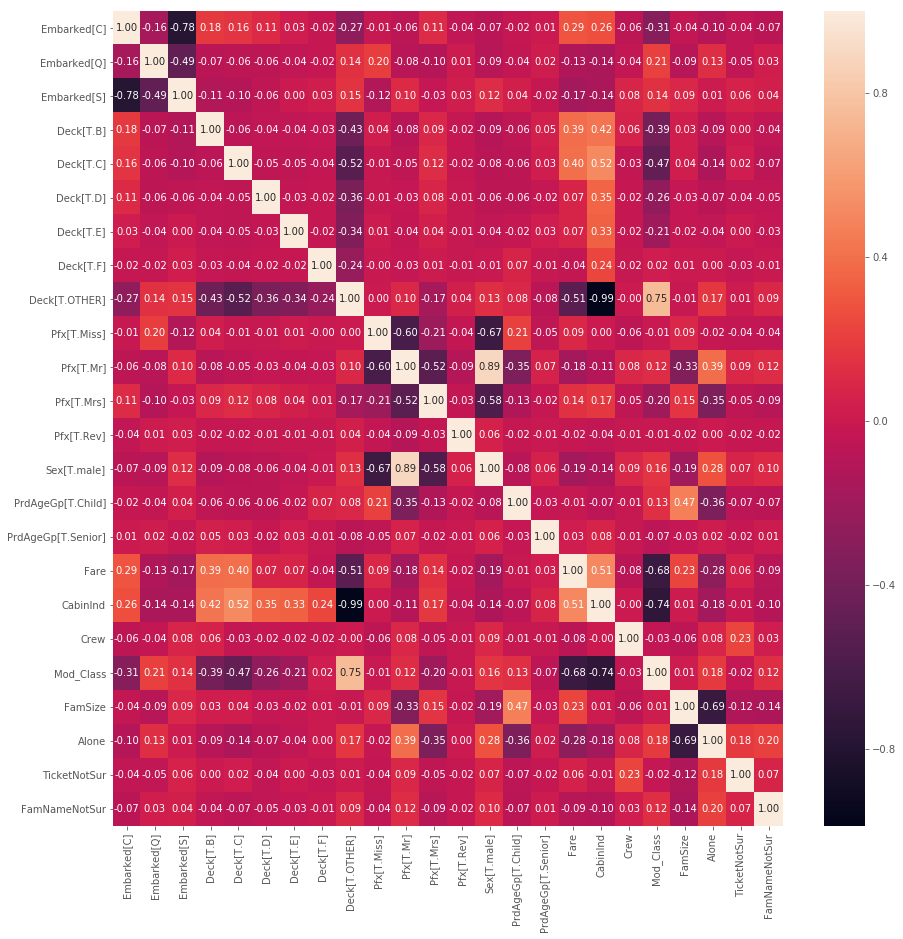

In [300]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(X.corr(), annot=True, fmt=".2f")

The Cabin indicator is extremely correlated with Deck[T.OTHER].  I will drop one.

In [301]:
X = X.drop(['CabinInd','Sex[T.male]'],axis=1)
X_reg = X_reg.drop(['CabinInd','Sex[T.male]'],axis=1)

## Save/Reload Checkpoint

### Save 

In [210]:
pickle.dump(X, open("X_data.p", "wb"))
pickle.dump(X_reg, open("X_reg_data.p", "wb"))

### Reload

In [274]:
X = pickle.load(open("X_data.p", "rb"))
X_reg = pickle.load(open("X_reg_data.p", "rb"))

## Split Up Train and Test Sets 

Picking the training and testing sets is already done for us, but it usually won't be. Here are some things to consider when you split up your sets
 * 

In [302]:
# Prepare dataset for most models
X_train = X[full_data['Survived'].notnull()].copy()
Y_train = Y[full_data['Survived'].notnull()].copy()

X_test = X[full_data['Survived'].isna()].copy()

# Prepare datasets for regression
X_reg_train = X_reg[full_data['Survived'].notnull()].copy()
Y_reg_train = Y_reg[full_data['Survived'].notnull()].copy()

X_reg_test = X_reg[full_data['Survived'].isna()].copy()

In [343]:
X_train.tail()

,Embarked[C],Embarked[Q],Embarked[S],Deck[T.B],Deck[T.C],Deck[T.D],Deck[T.E],Deck[T.F],Deck[T.OTHER],Pfx[T.Miss],...,Pfx[T.Mrs],Pfx[T.Rev],Sex[T.male],PrdAgeGp[T.Child],PrdAgeGp[T.Senior],Fare,Crew,Mod_Class,FamSize,Alone
PassengerId,,,,,,,,,,,,,,,,,,,,,
887,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,13.00,0.0,3.0,0.0,1.0
888,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,30.00,0.0,2.0,0.0,1.0
889,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,23.45,0.0,4.0,3.0,0.0
890,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,30.00,0.0,2.0,0.0,1.0
891,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,7.75,0.0,4.0,0.0,1.0


In [256]:
X_test.tail()

,Embarked[C],Embarked[Q],Embarked[S],Deck[T.B],Deck[T.C],Deck[T.D],Deck[T.E],Deck[T.F],Deck[T.OTHER],Pfx[T.Miss],Pfx[T.Mr],Pfx[T.Mrs],Pfx[T.Rev],Sex[T.male],Fare,Crew,AgeGpIntRaw,Mod_Class,FamSize,Alone
PassengerId,,,,,,,,,,,,,,,,,,,,
1305,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,8.0500,0.0,3.0,4.0,0.0,1.0
1306,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,108.9000,0.0,1.0,1.0,0.0,1.0
1307,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,7.2500,0.0,1.0,4.0,0.0,1.0
1308,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,8.0500,0.0,3.0,4.0,0.0,1.0
1309,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,22.3583,0.0,3.0,4.0,2.0,0.0


[Link to Survival Models](#to_srv_mdl)

# Modeling 

## Selecting a Model

* Classify your problem
    * We have a Binary Classification problem for Survival
    * We have a Non-Binary Classification problem for Age Group
* Determine appropriate models to fit problem type
    * We will be using supervised learning models
* Determine goal of the model
    * Obtain best result
    * Easily interpretable
    * Variable importance
* Model Coolness

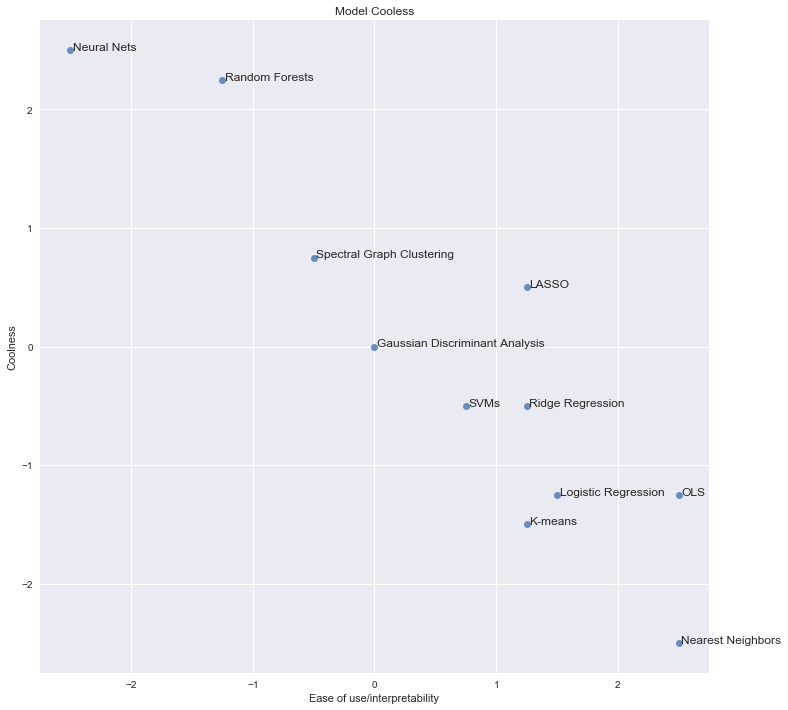

In [478]:
cool = pd.read_csv('Coolness.csv')

sns.set()

plt.figure(figsize=(12, 12))
ax=plt.subplot(111)
plt.title("Model Cooless")


sns.regplot(y='Coolness', x=cool.columns[1], data=cool, fit_reg=False, ax=ax)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(cool[cool.columns[1]], cool.Coolness ,cool.Algorithm, plt.gca()) 

Notes
* OLS gains coolness points for being OG
* While Nearest Neighbors is super boring, data structures to run it efficiently, like k-d trees, are super cool
* Using the kernel trick to use polynomial features implicitly without having to compute them adds +1 to your coolness
* If instead of the polynomial kernel you use a Gaussian kernel (which implicitly uses infinite dimensional feature vectors), adds +2 to coolness
* LASSO gains coolness points over Ridge for its tendency to also do feature selection
* K-means gains coolness but loses interpretability if you define a metric other than euclidean distance

<a id='to_age_gp_mdl'></a>

## Evaluating Model Performance

In [114]:
HTML('<img src="https://memecreator.org/static/images/memes/4818429.jpg" width="500">')

In [260]:
full_data['pessimisticPrediction'] = 0

tn = full_data[(full_data.Survived == 0) & (full_data.pessimisticPrediction==0)].index.size
fp = full_data[(full_data.Survived == 0) & (full_data.pessimisticPrediction==1)].index.size
fn = full_data[(full_data.Survived == 1) & (full_data.pessimisticPrediction==0)].index.size
tp = full_data[(full_data.Survived == 1) & (full_data.pessimisticPrediction==1)].index.size

precision , recall, accuracy = (float(tp)/(tp+fp+1),float(tp)/(tp+fn), float(tp+tn)/float(tp+tn+fp+fn))
f1score = 2*precision * recall / (precision + recall+1)

print('\n Confusion Matrix')
display(
pd.DataFrame(data={' Predicted Survived': ['True Positive: '+str(tp), 'False Positive: '+str(fp)], 
                   'Predicted Not Survived': ['False Negative: '+str(fn), 'True Negative: '+str(tn)]}, index=['Survived','Not Survived']))

display(
pd.DataFrame(data={'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'], 
                   'Performance': [precision, recall, f1score, accuracy]}))

## Append to scores table
new_row = pd.DataFrame([['pessimisticPrediction',precision, recall, f1score, accuracy,0.616]], columns=score_cols)
scores = scores.append(new_row)


 Confusion Matrix


,Predicted Survived,Predicted Not Survived
Survived,True Positive: 0,False Negative: 342
Not Survived,False Positive: 0,True Negative: 549


,Metric,Performance
0,Precision,0.000000
1,Recall,0.000000
2,F1 Score,0.000000
3,Accuracy,0.616162


### Age Group Model

### Decision Tree 

In [196]:
clf = DecisionTreeClassifier(max_features='auto',min_samples_split=5, max_depth=10)
%time treeResult = clf.fit(X_age_train,Y_age_train)

train_RSLTS = pd.merge(X_age_train, Y_age_train, left_index=True, right_index=True)
train_RSLTS['treePrediction'] = treeResult.predict(X_age_train)
train_RSLTS['treePredicProba'] = treeResult.predict_proba(X_age_train)[:,1]

CPU times: user 1.47 ms, sys: 971 µs, total: 2.44 ms
Wall time: 1.49 ms


#### Confusion Matrix 

In [197]:
pd.DataFrame(confusion_matrix(Y_age_train, train_RSLTS['treePrediction']),
             columns=['Predicted Child','Predicted Adult','Predicted Senior'],
            index=['Actually Child','Actually Adult','Actually Senior'])

,Predicted Child,Predicted Adult,Predicted Senior
Actually Child,72,19,0
Actually Adult,17,925,0
Actually Senior,0,13,0


#### Precision, Recall, F1 Score, Accuracy

__Precision:__ $\large \frac{True~Positve}{All~Positive~Predictions}$
* How well the model picks out positive value correctly
* Penalizes false positives
* Prioritized where false positives have high cost
    * Email spam detection
<br/>

__Recall:__ $\large \frac{True~Positve}{All~Actual~Positives}$

* How well the model predicts positive values
* Penalizes false negatives
* Prioritized where false negatives have high cost
    * Predicting credit card fraud
<br/>    
 
__F1 Score:__ $\large 2*\frac{Precision*Recall}{Precision+Recall}$
* Combination of Precision and Recall
* Better than accuracy for unbalanced datasets (many actual negatives)
<br/>

__Accuracy:__ $\large \frac{Correct~Predictions}{Total~Records}$
* How well your model predicts either response correctly from all records
* Is more representative if response is balanced

In [244]:
%%capture --no-stdout
print(classification_report(Y_age_train, train_RSLTS['treePrediction'], target_names=['Child','Adult','Senior']))

             precision    recall  f1-score   support

      Child       0.77      0.82      0.80        91
      Adult       0.97      0.98      0.97       942
     Senior       0.00      0.00      0.00        13

avg / total       0.94      0.95      0.95      1046



### Decision Tree with Cross Validation 

In [198]:
clf = DecisionTreeClassifier(max_features='auto',min_samples_split=5, max_depth=10)
%time treeResult = clf.fit(X_age_train,Y_age_train)
train_RSLTS = pd.merge(X_age_train, Y_age_train, left_index=True, right_index=True)
train_RSLTS['treePrediction'] = cross_val_predict(treeResult, X_age_train, Y_age_train, cv=10)

CPU times: user 1.43 ms, sys: 976 µs, total: 2.4 ms
Wall time: 1.44 ms


__Confusion Matrix__

In [199]:
pd.DataFrame(confusion_matrix(Y_age_train, train_RSLTS['treePrediction']),
             columns=['Predicted Child','Predicted Adult','Predicted Senior'],
            index=['Actually Child','Actually Adult','Actually Senior'])

#confusion_matrix(Y_age_train, train_RSLTS['treePrediction'], labels=[0.0, 1.0, 2.0])

,Predicted Child,Predicted Adult,Predicted Senior
Actually Child,75,16,0
Actually Adult,22,919,1
Actually Senior,0,13,0


__Precision, Recall, F1 Score, and Accuracy__

In [243]:
%%capture --no-stdout
print(classification_report(Y_age_train, train_RSLTS['treePrediction'], target_names=['Child','Adult','Senior']))

             precision    recall  f1-score   support

      Child       0.77      0.82      0.80        91
      Adult       0.97      0.98      0.97       942
     Senior       0.00      0.00      0.00        13

avg / total       0.94      0.95      0.95      1046



Performance: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix

### Predict Missing Age Groups

In [200]:
# Predicts and updates the 
full_data.loc[full_data['AgeGroup']=='Missing',['AgeGpIntRaw']] = treeResult.predict(X_age_pred)
full_data['PrdAgeGp'] = 'Child'
full_data.loc[full_data['AgeGpIntRaw']==1,['PrdAgeGp']] = 'Adult'
full_data.loc[full_data['AgeGpIntRaw']==2,['PrdAgeGp']] = 'Senior'

In [162]:
full_data[full_data['AgeGroup']=='Missing'].head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,...,Pfx,AgeGroup,Crew,FamSize,Alone,TicketNotSur,FamNameNotSur,AgeGpIntRaw,pessimisticPrediction,PrdAgeGp
PassengerId,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,3,male,0,0.0,...,Mr,Missing,0,0,1,0,0,1.0,0,Adult
18,NaN,NaN,S,13.0000,"Williams, Mr. Charles Eugene",0,2,male,0,1.0,...,Mr,Missing,0,0,1,0,1,1.0,0,Adult
20,NaN,NaN,C,7.2250,"Masselmani, Mrs. Fatima",0,3,female,0,1.0,...,Mrs,Missing,0,0,1,0,0,1.0,0,Adult
27,NaN,NaN,C,7.2250,"Emir, Mr. Farred Chehab",0,3,male,0,0.0,...,Mr,Missing,0,0,1,0,0,1.0,0,Adult
29,NaN,NaN,Q,7.8792,"O'Dwyer, Miss. Ellen ""Nellie""",0,3,female,0,1.0,...,Miss,Missing,0,0,1,0,0,1.0,0,Adult


[Link back to data preparation for survival prediction](#to_mdl_prp)

<a id='to_srv_mdl'></a>

### Predicting Survival 

#### Logistic Regression 

In [213]:
X_reg_train.head()

,Intercept,Embarked[T.Q],Embarked[T.S],Deck[T.B],Deck[T.C],Deck[T.D],Deck[T.E],Deck[T.F],Deck[T.OTHER],Pfx[T.Miss],Pfx[T.Mr],Pfx[T.Mrs],Pfx[T.Rev],PrdAgeGp[T.Child],PrdAgeGp[T.Senior],Fare,Crew,Mod_Class,FamSize,Alone
PassengerId,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,7.2500,0.0,4.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,71.2833,0.0,2.0,1.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,7.9250,0.0,4.0,0.0,1.0
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,53.1000,0.0,2.0,1.0,0.0
5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0500,0.0,4.0,0.0,1.0


In [303]:
lrf = LogisticRegression(fit_intercept=False)
%time logitResult = lrf.fit(X_reg_train,Y_reg_train.values.ravel())
#cross_val_predict(forestResults, x, y, cv=10)

RSLTS = pd.merge(X_reg_train, Y_reg_train, left_index=True, right_index=True)
#RSLTS['logitPrediction'] = logitResult.predict(X_reg_train)
RSLTS['logitPrediction'] = cross_val_predict(logitResult, X_reg_train, Y_reg_train.values.ravel(), cv=10)
RSLTS['logitPredicProba'] = cross_val_predict(logitResult, X_reg_train, Y_reg_train.values.ravel(), cv=10, method='predict_proba')[:,1]

tn = RSLTS[(RSLTS.ModSurv == 0) & (RSLTS.logitPrediction==0)].index.size
fp = RSLTS[(RSLTS.ModSurv == 0) & (RSLTS.logitPrediction==1)].index.size
fn = RSLTS[(RSLTS.ModSurv == 1) & (RSLTS.logitPrediction==0)].index.size
tp = RSLTS[(RSLTS.ModSurv == 1) & (RSLTS.logitPrediction==1)].index.size

precision, recall, accuracy = (float(tp)/(tp+fp),float(tp)/(tp+fn), float(tp+tn)/float(tp+tn+fp+fn))
f1score = 2*precision * recall / (precision + recall)

print('\n Confusion Matrix')
display(
pd.DataFrame(data={' Predicted Survived': ['True Positive: '+str(tp), 'False Positive: '+str(fp)], 
                   'Predicted Not Survived': ['False Negative: '+str(fn), 'True Negative: '+str(tn)]}, index=['Survived','Not Survived']))

display(
pd.DataFrame(data={'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'], 
                   'Performance': [precision, recall, f1score, accuracy]}))

## Append to scores table
new_row = pd.DataFrame([['Simple_Logistic_Regression',precision, recall, f1score, accuracy,0]], columns=score_cols)
scores = scores.append(new_row)

CPU times: user 2.96 ms, sys: 870 µs, total: 3.83 ms
Wall time: 2.87 ms

 Confusion Matrix


,Predicted Survived,Predicted Not Survived
Survived,True Positive: 258,False Negative: 84
Not Survived,False Positive: 68,True Negative: 481


,Metric,Performance
0,Precision,0.791411
1,Recall,0.754386
2,F1 Score,0.772455
3,Accuracy,0.829405


##### ROC Curve

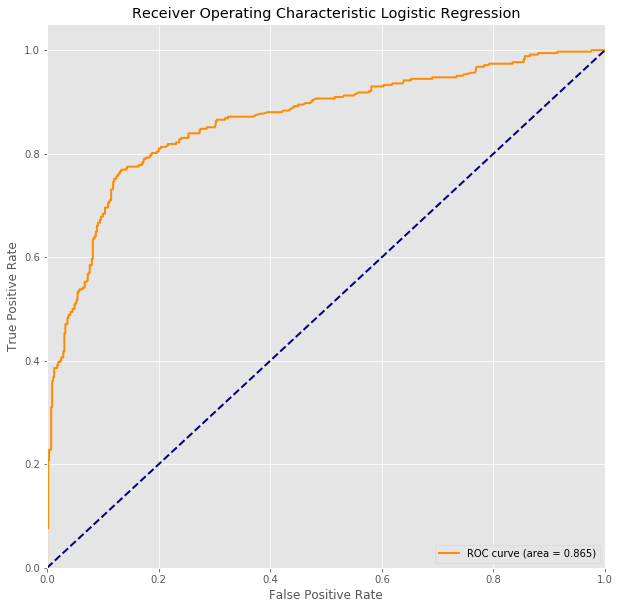

In [304]:
fpr, tpr, thresholds = roc_curve(RSLTS['ModSurv'], RSLTS['logitPredicProba'])

# Update ROC score
scores.loc[scores['Model']=='Simple_Logistic_Regression',['ROC_Area']] = roc_auc_score(RSLTS['ModSurv'], RSLTS['logitPredicProba'])

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw,label = 'ROC curve (area = %0.3f)' % roc_auc_score(RSLTS['ModSurv'], RSLTS['logitPredicProba']))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Logistic Regression')
plt.legend(loc="lower right")
plt.show()

#### Kitchen Sink Approach

In [184]:
HTML('<img src="https://www.hodgepodge.me/wp-content/uploads/2012/12/piled-up-dishes-in-kitchen-sink.jpg" width="600";>')

- [Decision Tree](http://scikit-learn.org/stable/modules/tree.html): Non-parametric learning using adaptive basis function, fit a multi-dimensional non-linear step function to your data
- [NNC](http://scikit-learn.org/stable/modules/neighbors.html): non-parametric learning in which the class of a data point is determined according the preponderance of classes in its neighborhood 
- [Stochastic Gradient Descent](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html): Fast implementation of a solver for a family of linear models
- [Gaussian Process Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html): 
- [Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html): Ensemble Method on Decision Tree, i.e. builds a model by aggregating several decision trees
- [Support Vector Machines](http://scikit-learn.org/stable/modules/svm.html): Finds a hyperplane that separates the classes of your data in some high-dimensional space


#### Back to Logistic Regression

##### Pros

* Linear
* Easy to understand
* Interpretable coefficients*
* Good computation time

##### Cons 

* Linear
* Heavily impacted by correlation and collinearity
* Fixing both the linear and correlation issues can be time consuming
* Performance may not always be great because things are usually not linear
* Coefficients can be misleading if dataset isn't groomed properly
* Relatively uncool

##### Solutions to Cons

* Correlation and collinearity
    * Identified with correlation matrices and variance inflation factors
    * Fixed by dropping or combining variables
    * Could also be fixed by dimensionality reduction, but that will impact interpretability
* Non-Linear
    * Take logs or decile features to make them more normal

##### Variable Importance - Coefficients

In [305]:
np.set_printoptions(suppress=True)
coefficients = pd.concat([pd.DataFrame(X_reg_train.columns),pd.DataFrame(np.transpose(logitResult.coef_))], axis = 1)
coefficients.columns = ['Feature', 'Coef']
coefficients.reindex(coefficients.Coef.abs().sort_values(ascending = False).index).head(50)

,Feature,Coef
0,Intercept,2.578508
10,Pfx[T.Mr],-2.173035
12,Pfx[T.Rev],-1.524989
11,Pfx[T.Mrs],1.190354
21,FamNameNotSur,-1.166798
6,Deck[T.E],0.883641
13,PrdAgeGp[T.Child],0.824067
14,PrdAgeGp[T.Senior],-0.716911
5,Deck[T.D],0.666378
16,Crew,-0.581558


##### Fixing Non-Linear Variables

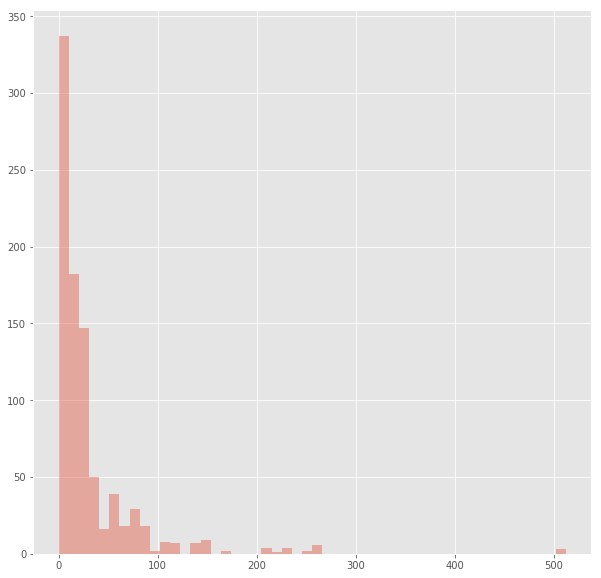

In [282]:
%%capture --no-display
sns.distplot(X_reg_train.loc[pd.notnull(X_reg_train["Fare"]),["Fare"]],kde=False)

##### Log of Fare

In [306]:
# Add Log of Fare
X_reg_train['LOG_Fare'] = np.log(X_reg_train['Fare'] + 1).values.ravel()

# Remove Fare
X_reg_train = X_reg_train.drop('Fare',axis=1)

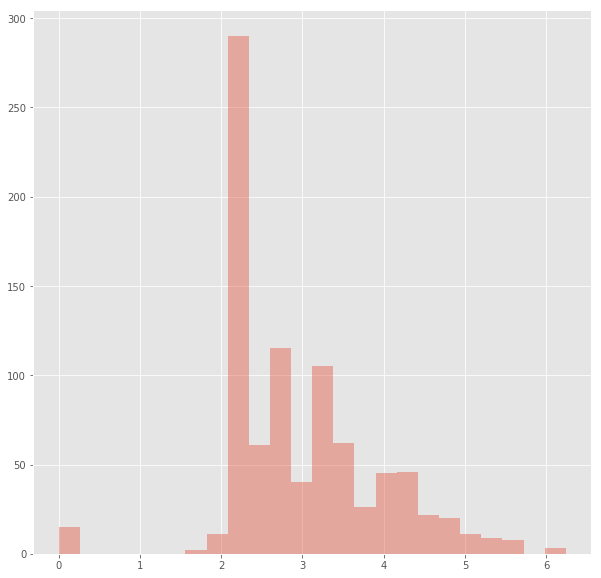

In [272]:
%%capture --no-display
sns.distplot(X_reg_train.loc[pd.notnull(X_reg_train["LOG_Fare"]),["LOG_Fare"]],kde=False)

##### Normalization - L Inf

In [307]:
##Linf xi norm = xi / max(x1,x2....xn)

norm = preprocessing.normalize(X_reg_train,norm='max',axis=0)

X_reg_train_norm = pd.DataFrame(data=norm[0:,0:],index=X_reg_train.index,columns=X_reg_train.columns)

#### Correlations and VIF

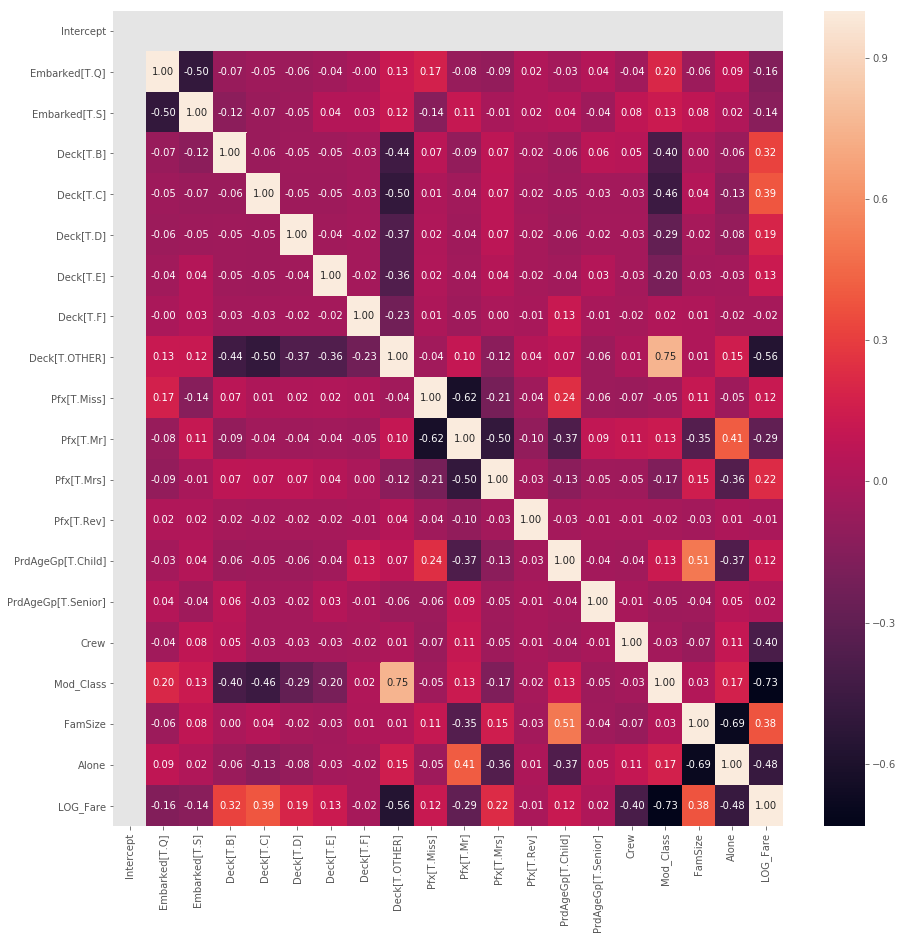

In [285]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(X_reg_train_norm.corr(), annot=True, fmt=".2f")

In [308]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_reg_train_norm.values, i) for i in range(X_reg_train_norm.shape[1])]
vif["features"] = X_reg_train_norm.columns
vif

,VIF Factor,features
0,379.718888,Intercept
1,1.556098,Embarked[T.Q]
2,1.516701,Embarked[T.S]
3,4.068449,Deck[T.B]
4,4.857288,Deck[T.C]
5,3.216862,Deck[T.D]
6,3.132197,Deck[T.E]
7,1.977288,Deck[T.F]
8,12.192517,Deck[T.OTHER]
9,6.731770,Pfx[T.Miss]


#####  Another Logistic Regression Run

In [309]:
lrf = LogisticRegression(fit_intercept=False)
%time logitResult = lrf.fit(X_reg_train_norm,Y_reg_train.values.ravel())
#cross_val_predict(forestResults, x, y, cv=10)

RSLTS = pd.merge(X_reg_train_norm, Y_reg_train, left_index=True, right_index=True)
RSLTS['logitPrediction'] = cross_val_predict(logitResult, X_reg_train_norm, Y_reg_train.values.ravel(), cv=10)
RSLTS['logitPredicProba'] = cross_val_predict(logitResult, X_reg_train_norm, Y_reg_train.values.ravel(), cv=10, method='predict_proba')[:,1]

tn = RSLTS[(RSLTS.ModSurv == 0) & (RSLTS.logitPrediction==0)].index.size
fp = RSLTS[(RSLTS.ModSurv == 0) & (RSLTS.logitPrediction==1)].index.size
fn = RSLTS[(RSLTS.ModSurv == 1) & (RSLTS.logitPrediction==0)].index.size
tp = RSLTS[(RSLTS.ModSurv == 1) & (RSLTS.logitPrediction==1)].index.size

precision, recall, accuracy = (float(tp)/(tp+fp),float(tp)/(tp+fn), float(tp+tn)/float(tp+tn+fp+fn))
f1score = 2*precision * recall / (precision + recall)

print('\n Confusion Matrix')
display(
pd.DataFrame(data={' Predicted Survived': ['True Positive: '+str(tp), 'False Positive: '+str(fp)], 
                   'Predicted Not Survived': ['False Negative: '+str(fn), 'True Negative: '+str(tn)]}, index=['Survived','Not Survived']))

display(
pd.DataFrame(data={'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'], 
                   'Performance': [precision, recall, f1score, accuracy]}))

## Append to scores table
new_row = pd.DataFrame([['Final_Logistic_Regression',precision, recall, f1score, accuracy,0]], columns=score_cols)
scores = scores.append(new_row)

CPU times: user 2.28 ms, sys: 779 µs, total: 3.06 ms
Wall time: 2.2 ms

 Confusion Matrix


,Predicted Survived,Predicted Not Survived
Survived,True Positive: 259,False Negative: 83
Not Survived,False Positive: 75,True Negative: 474


,Metric,Performance
0,Precision,0.775449
1,Recall,0.757310
2,F1 Score,0.766272
3,Accuracy,0.822671


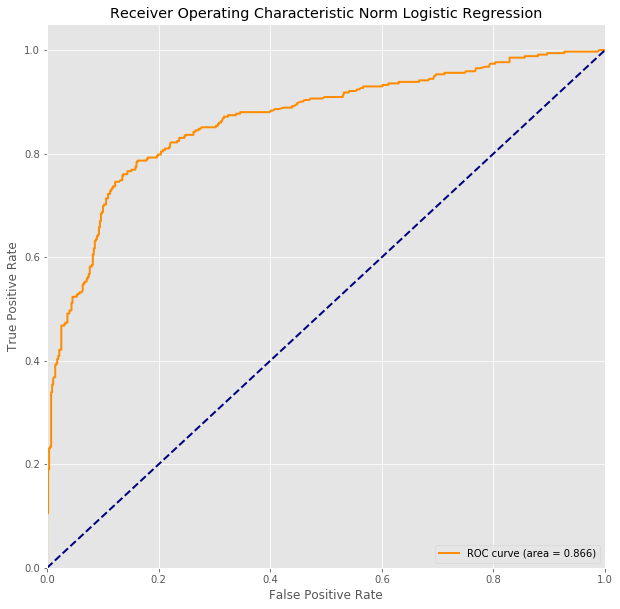

In [310]:
fpr, tpr, thresholds = roc_curve(RSLTS['ModSurv'], RSLTS['logitPredicProba'])

# Update ROC score
scores.loc[scores['Model']=='Final_Logistic_Regression',['ROC_Area']] = roc_auc_score(RSLTS['ModSurv'], RSLTS['logitPredicProba'])

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw,label = 'ROC curve (area = %0.3f)' % roc_auc_score(RSLTS['ModSurv'], RSLTS['logitPredicProba']))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Norm Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [311]:
np.set_printoptions(suppress=True)
coefficients = pd.concat([pd.DataFrame(X_reg_train_norm.columns),pd.DataFrame(np.transpose(logitResult.coef_))], axis = 1)
coefficients.columns = ['Feature', 'Coef']
coefficients.reindex(coefficients.Coef.abs().sort_values(ascending = False).index).head(50)

,Feature,Coef
17,FamSize,-2.673086
10,Pfx[T.Mr],-2.225047
0,Intercept,1.776089
12,Pfx[T.Rev],-1.526087
21,LOG_Fare,1.376362
16,Mod_Class,-1.308721
20,FamNameNotSur,-1.170127
11,Pfx[T.Mrs],1.016903
6,Deck[T.E],0.811566
14,PrdAgeGp[T.Senior],-0.786021


#### Decision Tree 

##### Pros

* Non-linear
* Adaptive basis function
* Visual representation*
* Interpretable*
* Many hyper-parameters to tune
* Medium high coolness

##### Cons 

* Dimensionality - Scales poorly with problem size
* Many hyper-parameters to tune
* Struggles with continuous/non-binary variables
* Different interpretation than Logistic Regression coefficients
* Variable importance is less understandable

##### Solutions to Cons 

* Dimensionality
    * Hyper-parameters
* Continuous/non-binary variables
    * Convert variables

##### Build Model 

In [312]:
clf = DecisionTreeClassifier(max_features='auto',min_samples_split=5, max_depth=4)
#clf = tree.DecisionTreeClassifier(max_features='auto')
%time treeResult = clf.fit(X_train,Y_train)

RSLTS = pd.merge(X_train, Y_train, left_index=True, right_index=True)
RSLTS['treePrediction'] = cross_val_predict(treeResult, X_train, Y_train.values.ravel(), cv=10)
RSLTS['treePredicProba'] = cross_val_predict(treeResult, X_train, Y_train.values.ravel(), cv=10, method='predict_proba')[:,1]

tn = RSLTS[(RSLTS.ModSurv == 0) & (RSLTS.treePrediction==0)].index.size
fp = RSLTS[(RSLTS.ModSurv == 0) & (RSLTS.treePrediction==1)].index.size
fn = RSLTS[(RSLTS.ModSurv == 1) & (RSLTS.treePrediction==0)].index.size
tp = RSLTS[(RSLTS.ModSurv == 1) & (RSLTS.treePrediction==1)].index.size

precision, recall, accuracy = (float(tp)/(tp+fp),float(tp)/(tp+fn), float(tp+tn)/float(tp+tn+fp+fn))
f1score = 2*precision * recall / (precision + recall)

print('\n Confusion Matrix')
display(
pd.DataFrame(data={' Predicted Survived': ['True Positive: '+str(tp), 'False Positive: '+str(fp)], 
                   'Predicted Not Survived': ['False Negative: '+str(fn), 'True Negative: '+str(tn)]}, index=['Survived','Not Survived']))

display(
pd.DataFrame(data={'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'], 
                   'Performance': [precision, recall, f1score, accuracy]}))

## Append to scores table
new_row = pd.DataFrame([['Simple_Decision_Tree',precision, recall, f1score, accuracy,0]], columns=score_cols)
scores = scores.append(new_row)

CPU times: user 1.26 ms, sys: 880 µs, total: 2.14 ms
Wall time: 1.17 ms

 Confusion Matrix


,Predicted Survived,Predicted Not Survived
Survived,True Positive: 219,False Negative: 123
Not Survived,False Positive: 68,True Negative: 481


,Metric,Performance
0,Precision,0.763066
1,Recall,0.640351
2,F1 Score,0.696343
3,Accuracy,0.785634


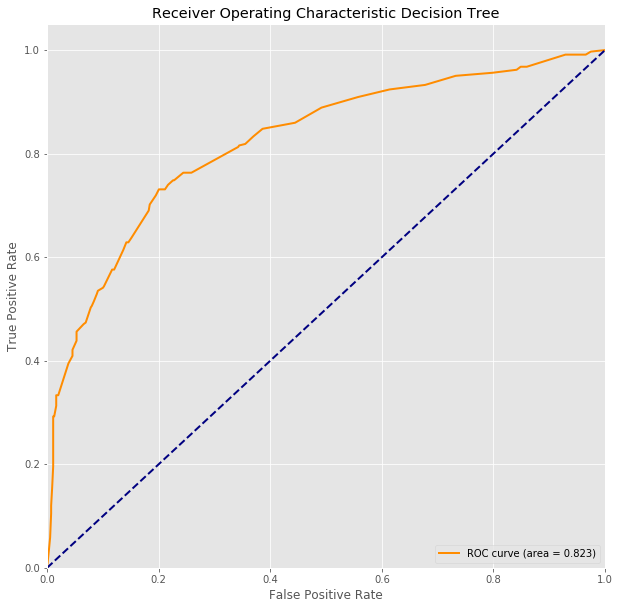

In [313]:
fpr, tpr, thresholds = roc_curve(RSLTS['ModSurv'], RSLTS['treePredicProba'])

# Update ROC score
scores.loc[scores['Model']=='Simple_Decision_Tree',['ROC_Area']] = roc_auc_score(RSLTS['ModSurv'], RSLTS['treePredicProba'])

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw,label = 'ROC curve (area = %0.3f)' % roc_auc_score(RSLTS['ModSurv'], RSLTS['treePredicProba']))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Decision Tree')
plt.legend(loc="lower right")
plt.show()

##### Variable Importance

In [314]:
importances_tree = pd.Series(dict((f,i) for f,i in zip(X_train.columns,treeResult.feature_importances_))).sort_values(ascending=False)
importances_tree.head(20)

Pfx[T.Miss]           0.440812
Pfx[T.Mrs]            0.314119
FamSize               0.060577
Pfx[T.Mr]             0.052088
Mod_Class             0.048541
Deck[T.OTHER]         0.040245
Fare                  0.024517
Alone                 0.011051
FamNameNotSur         0.007199
Embarked[C]           0.000851
Deck[T.E]             0.000000
Crew                  0.000000
Deck[T.B]             0.000000
Deck[T.C]             0.000000
Deck[T.D]             0.000000
TicketNotSur          0.000000
Deck[T.F]             0.000000
Embarked[Q]           0.000000
PrdAgeGp[T.Senior]    0.000000
Pfx[T.Rev]            0.000000
dtype: float64

##### Visualize Tree

In [476]:
with open("Titanic.dot", 'w') as f:
        export_graphviz(treeResult, out_file=f,
                        feature_names=X_train.columns)

        
subprocess.check_call(["dot", "-Tpng", "Titanic.dot", "-o", "Titanic.png"])

0

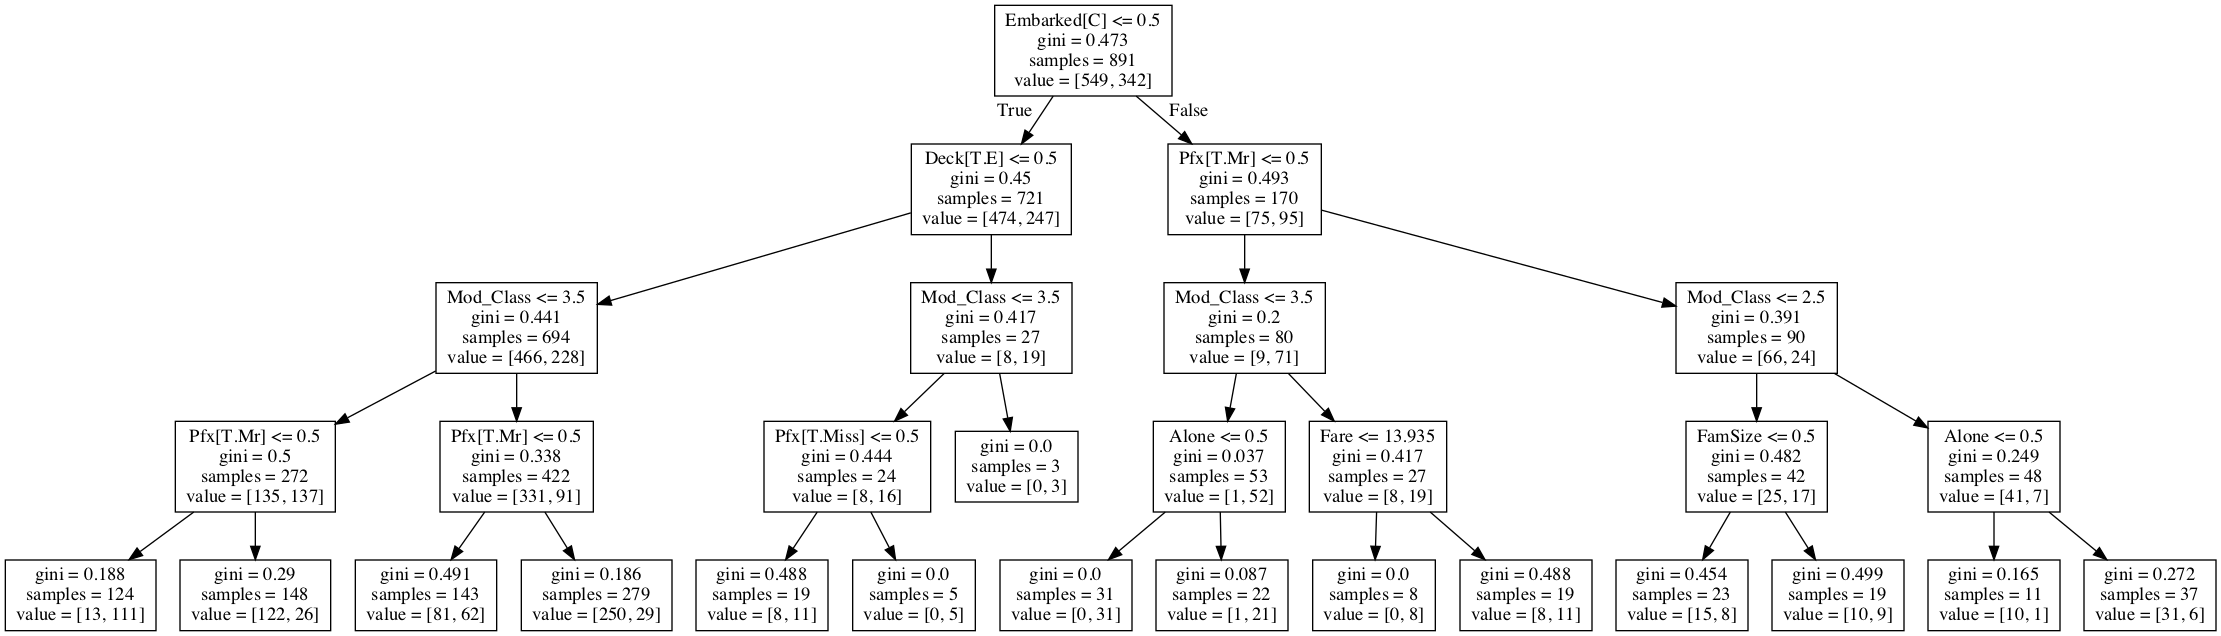

In [477]:
display(Image(filename="Titanic.png"))

##### Optimizing Hyper-parameters: Extra Trees

In [321]:
params = [
    {'n_estimators' : [10, 50],
     'criterion' : ['gini', 'entropy'],
     'max_features' : [5, 7, 9, 11],
     'max_depth' : [2, 5, 10, 20],
    }
]

learner = ExtraTreesClassifier()
ExtraTreesResult = GridSearchCV(learner, params)
#ExtraTreesResult.fit(X_train, Y_train.values.ravel())
#ExtraTreesResult.best_score_

RSLTS = pd.merge(X_train, Y_train, left_index=True, right_index=True)
RSLTS['extraTreePrediction'] = cross_val_predict(ExtraTreesResult, X_train, Y_train.values.ravel(), cv=10)
RSLTS['extraTreePredicProba'] = cross_val_predict(ExtraTreesResult, X_train, Y_train.values.ravel(), cv=10, method='predict_proba')[:,1]

tn = RSLTS[(RSLTS.ModSurv == 0) & (RSLTS.extraTreePrediction==0)].index.size
fp = RSLTS[(RSLTS.ModSurv == 0) & (RSLTS.extraTreePrediction==1)].index.size
fn = RSLTS[(RSLTS.ModSurv == 1) & (RSLTS.extraTreePrediction==0)].index.size
tp = RSLTS[(RSLTS.ModSurv == 1) & (RSLTS.extraTreePrediction==1)].index.size

precision, recall, accuracy = (float(tp)/(tp+fp),float(tp)/(tp+fn), float(tp+tn)/float(tp+tn+fp+fn))
f1score = 2*precision * recall / (precision + recall)

print('\n Confusion Matrix')
display(
pd.DataFrame(data={' Predicted Survived': ['True Positive: '+str(tp), 'False Positive: '+str(fp)], 
                   'Predicted Not Survived': ['False Negative: '+str(fn), 'True Negative: '+str(tn)]}, index=['Survived','Not Survived']))

display(
pd.DataFrame(data={'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'], 
                   'Performance': [precision, recall, f1score, accuracy]}))

## Append to scores table
new_row = pd.DataFrame([['Extra_Trees',precision, recall, f1score, accuracy,0]], columns=score_cols)
scores = scores.append(new_row)


 Confusion Matrix


,Predicted Survived,Predicted Not Survived
Survived,True Positive: 246,False Negative: 96
Not Survived,False Positive: 63,True Negative: 486


,Metric,Performance
0,Precision,0.796117
1,Recall,0.719298
2,F1 Score,0.755760
3,Accuracy,0.821549


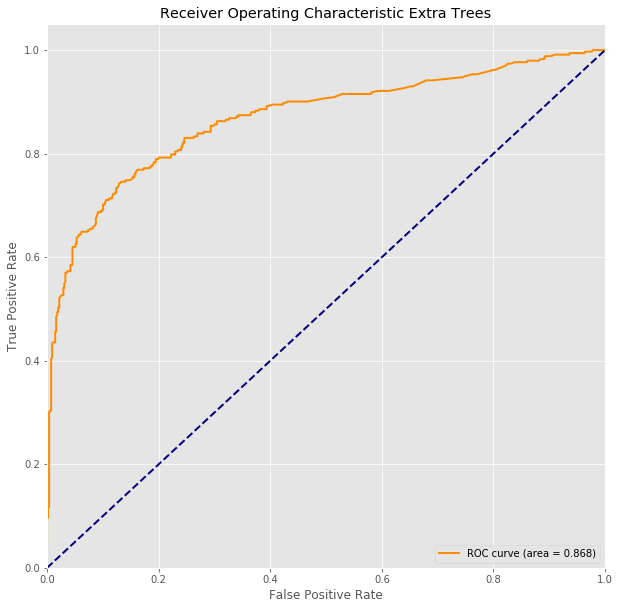

In [322]:
fpr, tpr, thresholds = roc_curve(RSLTS['ModSurv'], RSLTS['extraTreePredicProba'])

# Update ROC score
scores.loc[scores['Model']=='Extra_Trees',['ROC_Area']] = roc_auc_score(RSLTS['ModSurv'], RSLTS['extraTreePredicProba'])

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw,label = 'ROC curve (area = %0.3f)' % roc_auc_score(RSLTS['ModSurv'], RSLTS['extraTreePredicProba']))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Extra Trees')
plt.legend(loc="lower right")
plt.show()

#### Random Forest

In [315]:
forest = RandomForestClassifier(min_samples_split=5,n_jobs=-2,n_estimators=1000, max_depth = 10)
%time forestResult = forest.fit(X_train,Y_train.values.ravel())

RSLTS = pd.merge(X_train, Y_train, left_index=True, right_index=True)
RSLTS['forestPrediction'] = cross_val_predict(forestResult, X_train, Y_train.values.ravel(), cv=10)
RSLTS['forestPredicProba'] = cross_val_predict(forestResult, X_train, Y_train.values.ravel(), cv=10, method='predict_proba')[:,1]


tn = RSLTS[(RSLTS.ModSurv == 0) & (RSLTS.forestPrediction==0)].index.size
fp = RSLTS[(RSLTS.ModSurv == 0) & (RSLTS.forestPrediction==1)].index.size
fn = RSLTS[(RSLTS.ModSurv == 1) & (RSLTS.forestPrediction==0)].index.size
tp = RSLTS[(RSLTS.ModSurv == 1) & (RSLTS.forestPrediction==1)].index.size

precision, recall, accuracy = (float(tp)/(tp+fp),float(tp)/(tp+fn), float(tp+tn)/float(tp+tn+fp+fn))
f1score = 2*precision * recall / (precision + recall)

print('\n Confusion Matrix')
display(
pd.DataFrame(data={' Predicted Survived': ['True Positive: '+str(tp), 'False Positive: '+str(fp)], 
                   'Predicted Not Survived': ['False Negative: '+str(fn), 'True Negative: '+str(tn)]}, index=['Survived','Not Survived']))

display(
pd.DataFrame(data={'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'], 
                   'Performance': [precision, recall, f1score, accuracy]}))

## Append to scores table
new_row = pd.DataFrame([['Simple_Random_Forest',precision, recall, f1score, accuracy,0]], columns=score_cols)
scores = scores.append(new_row)

CPU times: user 1.7 s, sys: 834 ms, total: 2.53 s
Wall time: 1.87 s

 Confusion Matrix


,Predicted Survived,Predicted Not Survived
Survived,True Positive: 249,False Negative: 93
Not Survived,False Positive: 62,True Negative: 487


,Metric,Performance
0,Precision,0.800643
1,Recall,0.728070
2,F1 Score,0.762634
3,Accuracy,0.826038


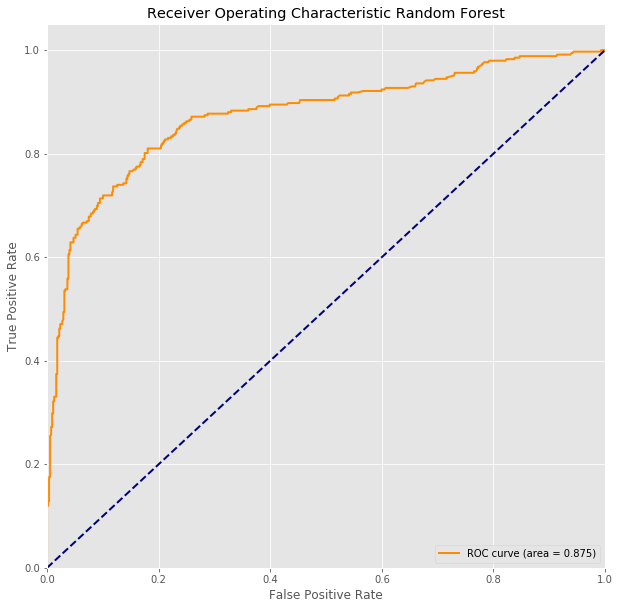

In [316]:
fpr, tpr, thresholds = roc_curve(RSLTS['ModSurv'], RSLTS['forestPredicProba'])

# Update ROC score
scores.loc[scores['Model']=='Simple_Random_Forest',['ROC_Area']] = roc_auc_score(RSLTS['ModSurv'], RSLTS['forestPredicProba'])

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw,label = 'ROC curve (area = %0.3f)' % roc_auc_score(RSLTS['ModSurv'], RSLTS['forestPredicProba']))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Random Forest')
plt.legend(loc="lower right")
plt.show()

# How Did We Do? 

In [319]:
scores.drop_duplicates(subset=['Model'], inplace=True, keep='last')

In [317]:
scores.drop_duplicates(subset=scores.columns, inplace=True, keep='last')

In [324]:
scores

,Model,Precision,Recall,F1_Score,Accuracy,ROC_Area
0,First_Pass_RF,0.606667,0.532164,0.566978,0.687991,0.790552
0,pessimisticPrediction,0.000000,0.000000,0.000000,0.616162,0.616
0,Extra_Trees,0.805281,0.713450,0.756589,0.823793,0.868107
0,Simple_Logistic_Regression,0.791411,0.754386,0.772455,0.829405,0.864504
0,Final_Logistic_Regression,0.775449,0.757310,0.766272,0.822671,0.866384
0,Simple_Decision_Tree,0.763066,0.640351,0.696343,0.785634,0.822599
0,Simple_Random_Forest,0.800643,0.728070,0.762634,0.826038,0.874589
0,Extra_Trees,0.796117,0.719298,0.755760,0.821549,0.868107


In [325]:
pickle.dump(X, open("scores.p", "wb"))

In [ ]:
score = pickle.load(open("scores.p", "rb"))

In [99]:
HTML('<img src="https://media.giphy.com/media/J12dgk74SczpC/giphy.gif" width="500">')

# Supporting Documents 

In [89]:
IFrame("../Notes/Pandas_Cheat_Sheet.pdf", width=1000, height=1600)

In [19]:
IFrame("../Notes/Python_Seaborn_Cheat_Sheet.pdf", width=1000, height=800)